<h1 align="center">Long Short-Term Memory (LSTM) </h1>

Cryptocurrency has become a popular and volatile investment in recent years, and forecasting the prices of various coins has become an important task for traders and investors. In this Jupyter notebook, we will use Long Short-Term Memory (LSTM) models to predict the closing prices of eight different cryptocurrencies. We will use PyTorch to implement the LSTM models and evaluate the performance of each model with various metrics.

## Steps

1. Data cleaning, feature engineering, and preprocessing: We will start by cleaning and preparing our data, which includes feature engineering and scaling the data.

2. Train-validation-test split: We will split the data into training, validation, and test sets, where the validation set will be used for monitoring the training process of the LSTM models, and the test set will be used for evaluating the final predictions.

3. PyTorch Dataset class initialization: We will create a PyTorch Dataset class object for our data to create the PyTorch dataloaders for our LSTM models.

4. Multilayer LSTM model architecture initialization: We will initialize the architecture of our multilayer LSTM model.

5. Training: We will train one LSTM model for each of the eight coins and evaluate the progress of training with metrics such as mean squared error (MSE), mean absolute error (MAE), coefficient of determination (R^2), and root mean squared error (RMSE) using the validation set.

6. Evaluation: We will evaluate each model and then compute the mean prediction for the eight coins.

7. Saving: We will save the test predictions and actual values and metrics for each coin to plot and evaluate later.

By following these steps, we hope to generate accurate predictions for cryptocurrency prices that can be used for trading or investment decisions, while also identifying the best LSTM architectures and hyperparameters for this task.


### Package imports and system configuration

In [52]:
from datetime import datetime
from os.path import join
import math
import time
import json


from tqdm.notebook import tqdm

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.graph_objs as go
from IPython.display import Markdown

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Necessary paths

In [43]:
data_raw_path ='io/input/data_raw/Crypto_July_2019_2023/4H_2019'
export_path = 'io/output/exports/'
test_path = 'io/input/base_data/test.csv'

predictions_path = export_path + 'predictions/'
metrics_plot_path = export_path + 'metrics_plots/'
results_path = export_path + 'experiments_results/'

###  Loading data

In [3]:
available_coins = ['ADA', 'BNB', 'BTC', 'DASH', 'ETH', 'LINK', 'LTC', 'XRP']
df = pd.DataFrame({'Available coins': available_coins})
display(df)

Available coins
0             ADA
1             BNB
2             BTC
3            DASH
4             ETH
5            LINK
6             LTC
7             XRP

In [4]:
def read_coin_data(coin_name: str) -> pd.DataFrame:    
    data_df = pd.read_csv(f"{data_raw_path}/{coin_name}/{coin_name.lower()}_2019.csv",index_col=False)
    return data_df

In [5]:
coin_name = 'BTC'
coin_df = read_coin_data(coin_name=coin_name)
coin_df = coin_df.rename(columns={"Time":"Date"})
coin_df.describe()

Open          High           Low         Close         Volume
count   7998.000000   7998.000000   7998.000000   7998.000000    7998.000000
mean   26023.127691  26307.312304  25716.448318  26024.899017   16697.992632
std    16867.231647  17070.209181  16646.291835  16866.391290   18398.636632
min     4565.630000   4950.000000   3782.130000   4565.590000       5.887034
25%    10166.767500  10260.605000  10089.070000  10166.827500    6268.326870
50%    20661.660000  20856.640000  20453.840000  20670.200000   10222.151561
75%    39938.240000  40422.075000  39425.010000  39938.152500   19505.728598
max    68490.000000  69000.000000  67627.140000  68490.000000  284711.694213

In [6]:
coin_df.head()

Date      Open      High       Low     Close        Volume
0  2019-07-20 16:00:00  10613.43  10995.00  10565.01  10898.66  12428.231815
1  2019-07-20 20:00:00  10898.66  11068.99  10656.85  10740.23   8769.733781
2  2019-07-21 00:00:00  10740.27  10817.90  10550.00  10575.15   7761.008844
3  2019-07-21 04:00:00  10577.36  10667.33  10530.00  10582.45   3815.251949
4  2019-07-21 08:00:00  10581.54  10745.98  10460.01  10585.11   8175.970572

### Exploratory analysis

In [7]:
def plot_coin_interactive(plot_df):
    plot_df = coin_df.copy()
    plot_df['Date'] = pd.to_datetime(plot_df['Date'])
    fig = px.line(plot_df, x='Date', y='Close', title=f'{coin_name} Close Price Over Time')
    fig.update_layout(xaxis_title='Date', yaxis_title='Close Price', xaxis_tickangle=-45)
    fig.show()
    
def plot_coin_static(plot_df):
    plot_df = coin_df.copy()
    plot_df['Date'] = pd.to_datetime(plot_df['Date'])

    plt.plot(plot_df['Date'], plot_df['Close'])
    plt.title(f'{coin_name} Close Price Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=-45)
    plt.ylabel('Close Price')
    plt.show()

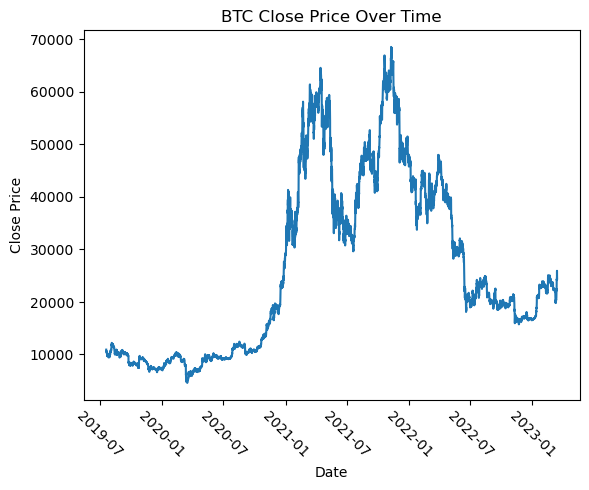

In [8]:
plot_coin_interactive(plot_df=coin_df)
plot_coin_static(plot_df=coin_df)

### Feature Engineering
* The purpose of the `append_date_features` function is to add additional date-related features to a pandas DataFrame. It enhances the original DataFrame by extracting various date components from a column named "Date" and appending them as separate columns.

* The purpose of the `create_trigonometric_columns` function is to create trigonometric representations of date-related columns in a pandas DataFrame. By converting the date components into sine and cosine values, **it captures cyclical patterns in a continuous numerical form**.



In [9]:
def append_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week
    return df

In [10]:
def create_trigonometric_columns(df) -> pd.DataFrame:
    # Create sine and cosine columns for Year, Month and Day
    df['Year_sin'] = df['Year'].apply(lambda x: math.sin(2*math.pi*x/2023))
    df['Year_cos'] = df['Year'].apply(lambda x: math.cos(2*math.pi*x/2023))
    df['Month_sin'] = df['Month'].apply(lambda x: math.sin(2*math.pi*x/12))
    df['Month_cos'] = df['Month'].apply(lambda x: math.cos(2*math.pi*x/12))
    df['Day_sin'] = df['Day'].apply(lambda x: math.sin(2*math.pi*x/31))
    df['Day_cos'] = df['Day'].apply(lambda x: math.cos(2*math.pi*x/31))
    return df

In [11]:
coin_df = append_date_features(df=coin_df)
coin_df = create_trigonometric_columns(df=coin_df)
# Set date as index
coin_df.set_index('Date', inplace=True)
coin_df.head()

Open      High       Low     Close        Volume  \
Date                                                                        
2019-07-20 16:00:00  10613.43  10995.00  10565.01  10898.66  12428.231815   
2019-07-20 20:00:00  10898.66  11068.99  10656.85  10740.23   8769.733781   
2019-07-21 00:00:00  10740.27  10817.90  10550.00  10575.15   7761.008844   
2019-07-21 04:00:00  10577.36  10667.33  10530.00  10582.45   3815.251949   
2019-07-21 08:00:00  10581.54  10745.98  10460.01  10585.11   8175.970572   

                     Year  Month  Day  Week_of_Year  Year_sin  Year_cos  \
Date                                                                      
2019-07-20 16:00:00  2019      7   20            29 -0.012423  0.999923   
2019-07-20 20:00:00  2019      7   20            29 -0.012423  0.999923   
2019-07-21 00:00:00  2019      7   21            29 -0.012423  0.999923   
2019-07-21 04:00:00  2019      7   21            29 -0.012423  0.999923   
2019-07-21 08:00:00  2019      7   21            29 -0.012423  0.999923   

                     Month_sin  Month_cos   Day_sin   Day_cos  
Date                                                           
2019-07-20 16:00:00       -0.5  -0.866025 -0.790776 -0.612106  
2019-07-20 20:00:00       -0.5  -0.866025 -0.790776 -0.612106  
2019-07-21 00:00:00       -0.5  -0.866025 -0.897805 -0.440394  
2019-07-21 04:00:00       -0.5  -0.866025 -0.897805 -0.440394  
2019-07-21 08:00:00       -0.5  -0.866025 -0.897805 -0.440394

### Create the target variable

The purpose of this function is to create a target variable that can be used for training a machine learning model to make predictions based on historical data. It achieves this by shifting the values of a specified column (commonly referred to as the "Close" column) in the DataFrame by a specified number of time steps (determined by the forecast_lead parameter).

In [18]:
def create_target_variable(df: pd.DataFrame, forecast_lead: int = 1) -> (pd.DataFrame, str):    
    target_column = "Close"
    features = list(df.columns.difference([target_column]))
    
    target_name = f"{target_column}_lead_{forecast_lead}"
    df[target_name] = df[target_column].shift(-forecast_lead)
    df = df.iloc[:-forecast_lead]
    return df, target_name

In [19]:
coin_df, target = create_target_variable(df=coin_df)
display("Target added to dataframe", coin_df[['Close', target]].head(), coin_df.shape)

'Target added to dataframe'

Close  Close_lead_1
Date                                       
2019-07-20 16:00:00  10898.66      10740.23
2019-07-20 20:00:00  10740.23      10575.15
2019-07-21 00:00:00  10575.15      10582.45
2019-07-21 04:00:00  10582.45      10585.11
2019-07-21 08:00:00  10585.11      10444.56

(7997, 16)

In [20]:
features = [col for col in coin_df.columns if col != target]
features_str = ', '.join(features)
display(Markdown(f"<strong>Features:</strong> {features_str}<br><strong>Target:</strong> {target}"))

<strong>Features:</strong> Open, High, Low, Close, Volume, Year, Month, Day, Week_of_Year, Year_sin, Year_cos, Month_sin, Month_cos, Day_sin, Day_cos<br><strong>Target:</strong> Close_lead_1

### Split data
* The purpose of the `split_train_valid_test` function is to split a pandas DataFrame into training, validation, and testing sets based on specific date ranges.


In [21]:
def split_train_valid_test(data: pd.DataFrame):    
    # Split the data into training and testing sets
    split_date_1 = datetime(2022, 1, 1)
    split_date_2 = datetime(2022, 12, 1)
    train_data = data.loc[data.index < split_date_1]
    valid_data = data.loc[(split_date_1<= data.index) & (data.index <= split_date_2)]
    test_data = data.loc[data.index > split_date_2]

    return train_data, valid_data, test_data


In [22]:
train_data, valid_data, test_data = split_train_valid_test(data=coin_df)
print("Train set fraction:", round((len(train_data) / len(coin_df)), 2),'%')
print("Valid set fraction:", round((len(valid_data) / len(coin_df)), 2),'%')
print("Test set fraction:", round((len(test_data) / len(coin_df)), 2),'%')
print("Train shape: ", train_data.shape)
train_data.head()

Train set fraction: 0.67 %
Valid set fraction: 0.25 %
Test set fraction: 0.08 %
Train shape:  (5370, 16)


Open      High       Low     Close        Volume  \
Date                                                                        
2019-07-20 16:00:00  10613.43  10995.00  10565.01  10898.66  12428.231815   
2019-07-20 20:00:00  10898.66  11068.99  10656.85  10740.23   8769.733781   
2019-07-21 00:00:00  10740.27  10817.90  10550.00  10575.15   7761.008844   
2019-07-21 04:00:00  10577.36  10667.33  10530.00  10582.45   3815.251949   
2019-07-21 08:00:00  10581.54  10745.98  10460.01  10585.11   8175.970572   

                     Year  Month  Day  Week_of_Year  Year_sin  Year_cos  \
Date                                                                      
2019-07-20 16:00:00  2019      7   20            29 -0.012423  0.999923   
2019-07-20 20:00:00  2019      7   20            29 -0.012423  0.999923   
2019-07-21 00:00:00  2019      7   21            29 -0.012423  0.999923   
2019-07-21 04:00:00  2019      7   21            29 -0.012423  0.999923   
2019-07-21 08:00:00  2019      7   21            29 -0.012423  0.999923   

                     Month_sin  Month_cos   Day_sin   Day_cos  Close_lead_1  
Date                                                                         
2019-07-20 16:00:00       -0.5  -0.866025 -0.790776 -0.612106      10740.23  
2019-07-20 20:00:00       -0.5  -0.866025 -0.790776 -0.612106      10575.15  
2019-07-21 00:00:00       -0.5  -0.866025 -0.897805 -0.440394      10582.45  
2019-07-21 04:00:00       -0.5  -0.866025 -0.897805 -0.440394      10585.11  
2019-07-21 08:00:00       -0.5  -0.866025 -0.897805 -0.440394      10444.56

## Preprocessing

This method creates a StandardScaler object and fits it on the training data only.
The scaler is then applied to transform the training, validation, and test input feature data. Finally, the method concatenates the transformed input feature data with their respective target variable and returns the resulting scaled training, validation, and test data as pandas dataframes.

In [23]:
def apply_scaling(train_data, valid_data, test_data, target):
    # Separate the input features and target variable in each dataframe
    X_train = train_data.drop(columns=[target])
    y_train = train_data[target]

    X_val = valid_data.drop(columns=[target])
    y_val = valid_data[target]

    X_test = test_data.drop(columns=[target])
    y_test = test_data[target]

    # Define a scaler object and fit it on the training data only
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    train_scaled = pd.concat([X_train_scaled, y_train],axis = 1)
    valid_scaled = pd.concat([X_valid_scaled, y_val],axis = 1)
    test_scaled = pd.concat([X_test_scaled, y_test],axis = 1)
    return train_scaled, valid_scaled, test_scaled

In [24]:
train_scaled, valid_scaled, test_scaled = apply_scaling(train_data, valid_data, test_data, target)

## Dataset class

Class definition for a custom PyTorch dataset, SequenceDataset, which takes a pandas DataFrame and converts it into a PyTorch tensor for sequence modeling. It includes, 
- __init__() method to set up the dataset with the desired target variable, input features, and sequence length.
- __len__() method returns the number of samples in the dataset
- __getitem__() method returns a single sample as a tuple of the input sequence x and the corresponding target y.

In [25]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [26]:
i = 5
sequence_length = 3
features = [col for col in train_scaled.columns if col != target]


train_dataset = SequenceDataset(
    train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
X, y

(tensor([[-0.7671, -0.7684, -0.7629, -0.7671, -0.8597, -1.6648, -0.0354,  0.5799,
          -0.0176, -1.6648, -1.7975, -0.5432, -1.3057, -1.2474, -0.6126],
         [-0.7668, -0.7644, -0.7665, -0.7670, -0.3267, -1.6648, -0.0354,  0.5799,
          -0.0176, -1.6648, -1.7975, -0.5432, -1.3057, -1.2474, -0.6126],
         [-0.7667, -0.7721, -0.7731, -0.7742, -0.2816, -1.6648, -0.0354,  0.5799,
          -0.0176, -1.6648, -1.7975, -0.5432, -1.3057, -1.2474, -0.6126]]),
 tensor(10406.5303))

In [27]:
train_data[features].iloc[(i - sequence_length + 1): (i + 1)]

Open      High       Low     Close       Volume  \
Date                                                                       
2019-07-21 04:00:00  10577.36  10667.33  10530.00  10582.45  3815.251949   
2019-07-21 08:00:00  10581.54  10745.98  10460.01  10585.11  8175.970572   
2019-07-21 12:00:00  10585.11  10596.43  10334.00  10444.56  8545.374253   

                     Year  Month  Day  Week_of_Year  Year_sin  Year_cos  \
Date                                                                      
2019-07-21 04:00:00  2019      7   21            29 -0.012423  0.999923   
2019-07-21 08:00:00  2019      7   21            29 -0.012423  0.999923   
2019-07-21 12:00:00  2019      7   21            29 -0.012423  0.999923   

                     Month_sin  Month_cos   Day_sin   Day_cos  
Date                                                           
2019-07-21 04:00:00       -0.5  -0.866025 -0.897805 -0.440394  
2019-07-21 08:00:00       -0.5  -0.866025 -0.897805 -0.440394  
2019-07-21 12:00:00       -0.5  -0.866025 -0.897805 -0.440394

### Creating and loading a PyTorch dataset and dataloader

- The **get_dataset_obj** function takes in a Pandas dataframe dataframe, a list of features features, a target variable target, and a sequence length sequence_length. It creates a SequenceDataset object using these inputs and returns it.

- The **get_dataloader** function takes in a dataset_obj, which is a SequenceDataset object, a batch size batch_size, and a boolean flag do_shuffle that indicates whether or not to shuffle the data. It creates a DataLoader object using these inputs and returns it. The DataLoader object is used to load the data in batches during training.

In [31]:
def get_dataset_obj(dataframe, features, target, sequence_length):
    sequence_dataset = SequenceDataset(
                            dataframe=dataframe,
                            target=target,
                            features=features,
                            sequence_length=sequence_length
                            )
    return sequence_dataset
    
def get_dataloader(dataset_obj, batch_size, do_shuffle = False):
    loader = DataLoader(dataset_obj, batch_size=batch_size, shuffle=do_shuffle)
    return loader

In [32]:
torch.manual_seed(99)
train_loader = DataLoader(train_dataset, batch_size=3)
X, y = next(iter(train_loader))
print(X.shape)

torch.Size([3, 16, 15])


In [33]:
sequence_length = 16
train_dataset = get_dataset_obj(train_scaled, target=target, features=features, sequence_length=sequence_length)
validation_dataset = get_dataset_obj(valid_scaled, target=target, features=features, sequence_length=sequence_length)
test_dataset = get_dataset_obj(test_scaled, target=target, features=features, sequence_length=sequence_length)

batch_size = 16
train_loader = get_dataloader(train_dataset, batch_size=batch_size, do_shuffle=True)
validation_loader = get_dataloader(validation_dataset, batch_size=batch_size)
test_loader = get_dataloader(test_dataset, batch_size=batch_size)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([16, 16, 15])
Target shape: torch.Size([16])


### Create DataLoaders for training

1. Load data of a crypto coin given its name and apply preprocessing.
2. Create a target variable and split the data into training, validation, and testing sets.
3. Apply scaling to the input features in each dataset.
4. Initialize PyTorch Dataset objects for the scaled data with a specified sequence length and target variable.
5. Initialize PyTorch DataLoader objects for each Dataset object with a specified batch size, and return the datasets, loaders, and target variable as output.

In [34]:
def prepare_data(coin: str, sequence_length, batch_size):
    df = read_coin_data(coin_name=coin)
    df.rename(columns={"Time":"Date"}, inplace=True)
    df = append_date_features(df=df)
    df = create_trigonometric_columns(df=df)
    df.set_index('Date', inplace=True)
    df, target = create_target_variable(df=df)
    train_df, valid_df, test_df = split_train_valid_test(data=df)
    datasets = (train_df, valid_df, test_df)
    train_scaled, valid_scaled, test_scaled = apply_scaling(train_df, valid_df, test_df, target)
    features = [col for col in train_data.columns if col != target]
    
    # initialize Dataset objects
    train_dataset = get_dataset_obj(train_scaled, target=target, features=features, sequence_length=sequence_length)
    validation_dataset = get_dataset_obj(valid_scaled, target=target, features=features, sequence_length=sequence_length)
    test_dataset = get_dataset_obj(test_scaled, target=target, features=features, sequence_length=sequence_length)

    # initialize DataLoader objects
    train_loader = get_dataloader(train_dataset, batch_size=batch_size)
    validation_loader = get_dataloader(validation_dataset, batch_size=batch_size)
    test_loader = get_dataloader(test_dataset, batch_size=batch_size)
    loaders = (train_loader, validation_loader, test_loader)
    
    return datasets, loaders, target
    

In [35]:
datasets, loaders, target = prepare_data(coin='BTC', sequence_length=16, batch_size=16)
train_loader, validation_loader, test_loader = loaders

### LSTM architecture
- Input:
  - Number of features: `num_sensors`

- LSTM Layer:
  - Input size: `num_sensors`
  - Hidden size: `hidden_units`
  - Batch first: True
  - Number of layers: `num_layers`

- Fully Connected Layers:
  - `fc1`:
    - Input features: `hidden_units`
    - Output features: 64
  - Dropout (`dropout1`) with a probability of `dropout_prob`
  - Batch normalization (`bn1`)
  - ReLU activation function (`relu1`)
  
  - `fc2`:
    - Input features: 64
    - Output features: 16
  - Dropout (`dropout2`) with a probability of `dropout_prob`
  - Batch normalization (`bn2`)
  - ReLU activation function (`relu2`)
  
  - `fc3`:
    - Input features: 16
    - Output features: 1

- Forward Pass:
  - Initialize the LSTM layer with zeros for the initial hidden state and cell state.
  - Pass the input through the LSTM layer.
  - Select the output of the last LSTM layer.
  - Pass the output through `fc1`, `relu1`, `fc2`, `dropout2`, `relu2`, and `fc3`.
  - Squeeze the output tensor to remove the last dimension of size 1.
  - Return the output.


In [36]:
class DeepRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, num_layers, dropout_prob=0.2):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,  # Use the first value in the list for the first layer
            batch_first=True,
            num_layers=self.num_layers
        )


        self.fc1 = nn.Linear(in_features=hidden_units, out_features=64)
        self.dropout1 = nn.Dropout(p=self.dropout_prob)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=64, out_features=16)
        self.dropout2 = nn.Dropout(p=self.dropout_prob)
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        # Pass input through the first LSTM layer
        out, (hn, _) = self.lstm(x, (h0.detach(), c0.detach()))

        out = hn[-1]  # Select the output of the last LSTM layer
        out = self.fc1(out)
#         out = self.dropout1(out)
#         out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.dropout2(out)
#         out = self.bn2(out)
        out = self.relu2(out)
        out = self.fc3(out).squeeze()  # Squeeze to remove the last dimension of size 1
        
        return out

In [37]:
num_hidden_units = 64
num_of_layers = 3
model = DeepRegressionLSTM(num_sensors=15, hidden_units=num_hidden_units, num_layers=num_of_layers)

## Training details

The **calculate_evalution_metrics** method calculates evaluation metrics for a given set of predictions and true values. The evaluation metrics include: 
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- R2 Score
- Root Mean Squared Error (RMSE)

In [38]:
def calculate_evaluation_metrics(y_pred, y_true, loss_fn):
    mse = loss_fn(y_pred, y_true)
    mae = torch.mean(torch.abs(y_pred - y_true))
    r2 = torchmetrics.functional.r2_score(y_pred.view(-1), y_true.view(-1))
    rmse = torch.sqrt(torch.mean(torch.pow(y_pred - y_true, 2)))
    
    return mse, mae, r2, rmse
        

1. `plot_comparison(actual, pred, coin)`: 
   - Goal: Plot a comparison between the actual and predicted values for a given coin's close prices.
   - Content: Plot the actual and predicted values on a graph.

2. `train_model(data_loader, model, loss_function, optimizer, ix_epoch)`: 
   - Goal: Train a given model using the provided data loader, loss function, and optimizer.
   - Content: 
     - Calculate evaluation metrics (MSE, MAE, R2, RMSE).
     - Return the trained model and computed metrics.

3. `evaluate_model(data_loader, model, loss_function, coin, ix_epoch = None)`: 
   - Goal: Evaluate a trained model using the provided data loader and loss function.
   - Content: 
     - Calculate the loss and evaluation metrics (MSE, MAE, R2, RMSE).
     - Plot a comparison between actual and predicted values if the epoch is divisible by 5.
     - Return the evaluated metrics as a dictionary.

4. `train_and_evaluate_model(train_loader, val_loader, model, loss_function, learning_rate, epochs, coin)`: 
   - Goal: Combine the training and evaluation processes for a given model.
   - Content: 
     - Train the model using the provided training data loader, loss function, optimizer, learning rate, and epochs.
     - Return the trained model.

5. `predict(data_loader, model)`: 
   - Goal: Predict output values using a trained model.
   - Content: Feed the input to the model and collect the predicted values.

In [52]:
def plot_comparison(actual, pred, coin):
    plt.plot(actual, label='actual')
    plt.plot(pred, label='prediction')
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.legend()
    plt.title(f'{coin} Validation actual vs prediction')
    plt.show()


def train_model(data_loader, model, loss_function, optimizer, ix_epoch) -> dict:
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    mse_list, mae_list, r2_list, rmse_list = [], [], [], []
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        # computes gradients of the loss
        loss.backward()
        # updates the model parameters
        optimizer.step()

        total_loss += loss.item()
    
        mse, mae, r2, rmse = calculate_evaluation_metrics(y_pred=output, y_true=y, loss_fn=loss_function)
        mse_list.append(mse.item())
        mae_list.append(mae.detach().numpy())
        r2_list.append(r2.detach().numpy())
        rmse_list.append(rmse.detach().numpy())
    
    mse = sum(mse_list) / num_batches
    mae = sum(mae_list) / num_batches
    r2 = sum(r2_list) / num_batches
    rmse = sum(rmse_list) / num_batches
    print("Epoch {}, Train || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(ix_epoch, mse, mae, r2, rmse))
    metrics = {'mse': mse, 'mae': mae, 'r2': r2, 'rmse': rmse}
    return model, metrics

def evaluate_model(data_loader, model, loss_function, coin, ix_epoch = None) -> dict:
    
    num_batches = len(data_loader)
    total_loss = 0

    mse_list, mae_list, r2_list, rmse_list = [], [], [], []
    
    model.eval()
    actual_, pred_ = [], []
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
            mse, mae, r2, rmse = calculate_evaluation_metrics(y_pred=output, y_true=y, loss_fn=loss_function)
            mse_list.append(mse.item())
            mae_list.append(mae.detach().numpy())
            r2_list.append(r2.detach().numpy())
            rmse_list.append(rmse.detach().numpy())
            
            actual_.append(y.numpy().reshape(-1))
            pred_.append(output.numpy().reshape(-1))
            
        actual_ = np.hstack(actual_)
        pred_ = np.hstack(pred_)
        

    mse = sum(mse_list) / num_batches
    mae = sum(mae_list) / num_batches
    r2 = sum(r2_list) / num_batches
    rmse = sum(rmse_list) / num_batches
    if ix_epoch is not None:
        print("Epoch {}, Evaluation || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(ix_epoch, mse, mae, r2, rmse))
    metrics = {'mse': mse, 'mae': mae, 'r2': r2, 'rmse': rmse}
    
    # plot every 2 epochs
    if ix_epoch is not None and ix_epoch % 5 == 0:   
        plot_comparison(actual=actual_, pred=pred_, coin=coin)
    return metrics

def train_and_evaluate_model(train_loader, val_loader, model, loss_function, learning_rate, epochs, coin):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start = time.time()
    for ix_epoch in tqdm(range(epochs), desc=f"Training {coin} coin..."):
        print("\n---------")
        num_batches = len(train_loader)
        total_loss = 0
        model.train()

        mse_list, mae_list, r2_list, rmse_list = [], [], [], []

        for X, y in train_loader:
            output = model(X)
            loss = loss_function(output, y)

            optimizer.zero_grad()
            # computes gradients of the loss
            loss.backward()
            # updates the model parameters
            optimizer.step()

            total_loss += loss.item()

            mse, mae, r2, rmse = calculate_evaluation_metrics(y_pred=output, y_true=y, loss_fn=loss_function)
            mse_list.append(mse.item())
            mae_list.append(mae.detach().numpy())
            r2_list.append(r2.detach().numpy())
            rmse_list.append(rmse.detach().numpy())

        mse = sum(mse_list) / num_batches
        mae = sum(mae_list) / num_batches
        r2 = sum(r2_list) / num_batches
        rmse = sum(rmse_list) / num_batches
        print("Epoch {}, Train || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(ix_epoch+1, mse, mae, r2, rmse))
        metrics = {'mse': mse, 'mae': mae, 'r2': r2, 'rmse': rmse}
        val_metrics = evaluate_model(val_loader, model, loss_function, coin, ix_epoch=ix_epoch+1)
        print()

    return model
 
    
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_pred = model(X)
            output = torch.cat((output, y_pred), 0)
    
    return output

### Train one model for each coin
1. `train_all_coins(coin_list: list, epochs, learning_rate, loss_function, num_hidden_units, num_of_layers, batch_size, sequence_length)`:
   - **Goal:** Train and evaluate regression models for a list of coins using the given parameters.
   - **Content:**
     - Initialize dictionaries and dataframes for storing model results, predictions, and actual values.
     - Iterate over each coin in the coin list.
     - Prepare data for the current coin.
     - Create an instance of the `DeepRegressionLSTM` model.
     - Train and evaluate the model using the training and validation data loaders.
     - Evaluate the model on the test data and store the test metrics.
     - Generate predictions using the trained model on the test data and store them in a dataframe.
     - Store the actual values of the test data in a dataframe.
     - Store the results, test predictions, and actual values for each coin.
     - Return the model results, predictions dataframe, and actual values dataframe.

2. `append_means(predictions_df, actual_df)`:
   - **Goal:** Append the column-wise mean values to the predictions and actual dataframes.
   - **Content:**
     - Compute the mean values for each column in the predictions and actual dataframes.
     - Append the mean values as new columns to the respective dataframes.
     - Return the updated predictions and actual dataframes.

3. `compute_mean_metrics(coin_results: dict)`:
   - **Goal:** Compute the mean values of the test metrics for all the coins.
   - **Content:**
     - Initialize variables to store the sum of the test metrics and the total number of coins.
     - Iterate over the results of each coin.
     - Accumulate the test metric values.
     - Calculate the mean values of the test metrics.
     - Create a new dictionary with the mean results and return it.


In [56]:
def train_all_coins(coin_list: list, epochs, learning_rate, loss_function, num_hidden_units,
                    num_of_layers, batch_size, sequence_length):
    
    
    model_results = {"learning_rate": learning_rate, "epochs": epochs, "batch_size": batch_size}
    model_results['results'] = {}
    predictions_df = pd.DataFrame()
    actual_df = pd.DataFrame()

    for coin in tqdm(coin_list, desc="Processing coins..."):
        results = {}
        datasets, loaders, target = prepare_data(coin=coin, sequence_length=sequence_length, batch_size=batch_size)
        train_dataset, validation_dataset, test_dataset = datasets
        train_loader, validation_loader, test_loader = loaders
        
        features = train_dataset.shape[1]-1
        model = DeepRegressionLSTM(num_sensors=features, hidden_units=num_hidden_units, num_layers=num_of_layers)
        
        trained_model = train_and_evaluate_model(train_loader, validation_loader, model, loss_function,
                                                  learning_rate, epochs, coin)
        test_metrics = evaluate_model(test_loader, trained_model, loss_function, coin=coin, ix_epoch=None)
        results['test_metrics'] = test_metrics
        test_predictions = predict(test_loader, trained_model).numpy()
        predictions_df[coin] = list(test_predictions)
        actual_df[coin] = test_dataset[target].tolist()
        model_results['results'][coin] = results
        
        
    predictions_df.index = test_dataset.index
    actual_df.index = test_dataset.index
    return model_results, predictions_df, actual_df

def append_means(predictions_df, actual_df):
    predictions_df['mean'] = predictions_df.mean(axis=1)
    actual_df['mean'] = actual_df.mean(axis=1)
    return predictions_df, actual_df

def compute_mean_metrics(coin_results: dict):
    num_of_coins = len(coin_results)
    sum_mse, sum_mae, sum_r2, sum_rmse, sum_time = 0, 0, 0, 0, 0
    results_dict = coin_results['results']
    for coin, results in results_dict.items():
        sum_mse += results['test_metrics']['mse']
        sum_mae += results['test_metrics']['mae']
        sum_r2 += results['test_metrics']['r2']
        sum_rmse += results['test_metrics']['rmse']

    mean_results = coin_results    
    mean_results['mean_mse'] = sum_mse/num_of_coins
    mean_results['mean_mae'] = sum_mae/num_of_coins
    mean_results['mean_r2'] = sum_r2/num_of_coins
    mean_results['mean_rmse'] = sum_rmse/num_of_coins
    
    return mean_results

Processing coins...:   0%|          | 0/8 [00:00<?, ?it/s]

Training ADA coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 0.1082756, MAE: 0.1903881, R2: -117.7035314, RMSE: 0.2230573
Epoch 1, Evaluation || MSE: 0.3485812, MAE: 0.5359136, R2: -7073.2211899, RMSE: 0.5373167


---------
Epoch 2, Train || MSE: 0.0918514, MAE: 0.1758512, R2: -153.0491225, RMSE: 0.2049559
Epoch 2, Evaluation || MSE: 0.4114485, MAE: 0.5889435, R2: -8039.4688324, RMSE: 0.5901779


---------
Epoch 3, Train || MSE: 0.0930577, MAE: 0.1598655, R2: -71.9029152, RMSE: 0.1888701
Epoch 3, Evaluation || MSE: 0.4431321, MAE: 0.6014155, R2: -9381.8079315, RMSE: 0.6027375


---------
Epoch 4, Train || MSE: 0.1425323, MAE: 0.2127046, R2: -273.0431103, RMSE: 0.2483915
Epoch 4, Evaluation || MSE: 0.4051591, MAE: 0.5713183, R2: -8650.2312055, RMSE: 0.5727993


---------
Epoch 5, Train || MSE: 0.2008269, MAE: 0.2731159, R2: -317.7742912, RMSE: 0.2967131
Epoch 5, Evaluation || MSE: 0.4813705, MAE: 0.6313040, R2: -10090.2542912, RMSE: 0.6325649


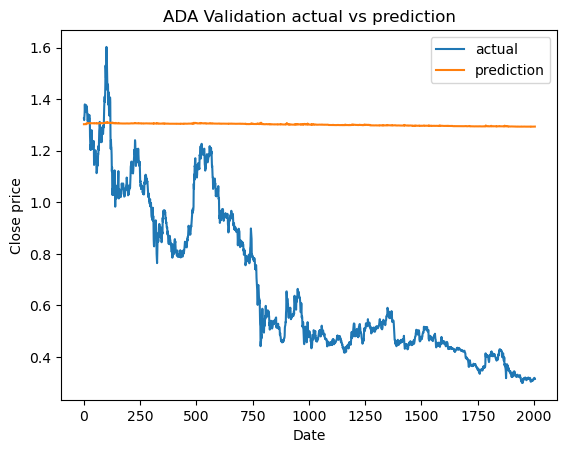



---------
Epoch 6, Train || MSE: 0.1647115, MAE: 0.2421510, R2: -250.3529515, RMSE: 0.2801623
Epoch 6, Evaluation || MSE: 0.5010858, MAE: 0.6489082, R2: -10334.7765814, RMSE: 0.6501868


---------
Epoch 7, Train || MSE: 0.1274544, MAE: 0.2146628, R2: -151.6065256, RMSE: 0.2430108
Epoch 7, Evaluation || MSE: 0.4641181, MAE: 0.6284079, R2: -9301.4531359, RMSE: 0.6296678


---------
Epoch 8, Train || MSE: 0.1083265, MAE: 0.1875548, R2: -131.6099343, RMSE: 0.2172570
Epoch 8, Evaluation || MSE: 0.4432057, MAE: 0.6294970, R2: -7950.1264445, RMSE: 0.6305908


---------
Epoch 9, Train || MSE: 0.0865187, MAE: 0.1803425, R2: -129.7495157, RMSE: 0.2152395
Epoch 9, Evaluation || MSE: 0.3219419, MAE: 0.5437435, R2: -4888.8208165, RMSE: 0.5449974


---------
Epoch 10, Train || MSE: 0.0859683, MAE: 0.1760712, R2: -124.9455259, RMSE: 0.2054730
Epoch 10, Evaluation || MSE: 0.4069818, MAE: 0.6099322, R2: -6862.3834774, RMSE: 0.6110504


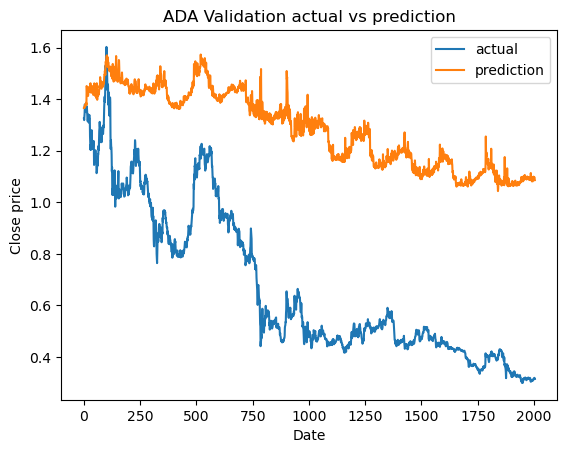



---------
Epoch 11, Train || MSE: 0.0720174, MAE: 0.1634280, R2: -104.2274424, RMSE: 0.1927215
Epoch 11, Evaluation || MSE: 0.3566008, MAE: 0.5632825, R2: -6621.4574791, RMSE: 0.5643599


---------
Epoch 12, Train || MSE: 0.0760576, MAE: 0.1732474, R2: -137.2406658, RMSE: 0.1997601
Epoch 12, Evaluation || MSE: 0.4281295, MAE: 0.6352358, R2: -6899.8953679, RMSE: 0.6359450


---------
Epoch 13, Train || MSE: 0.0702008, MAE: 0.1600906, R2: -103.8494261, RMSE: 0.1901897
Epoch 13, Evaluation || MSE: 0.5843216, MAE: 0.7543685, R2: -7895.4844711, RMSE: 0.7549296


---------
Epoch 14, Train || MSE: 0.0620551, MAE: 0.1507146, R2: -97.4693717, RMSE: 0.1802014
Epoch 14, Evaluation || MSE: 0.5566199, MAE: 0.7321539, R2: -6321.0923625, RMSE: 0.7327357


---------
Epoch 15, Train || MSE: 0.0525851, MAE: 0.1427594, R2: -98.0820515, RMSE: 0.1715355
Epoch 15, Evaluation || MSE: 0.5677627, MAE: 0.7337736, R2: -6498.4175509, RMSE: 0.7343262


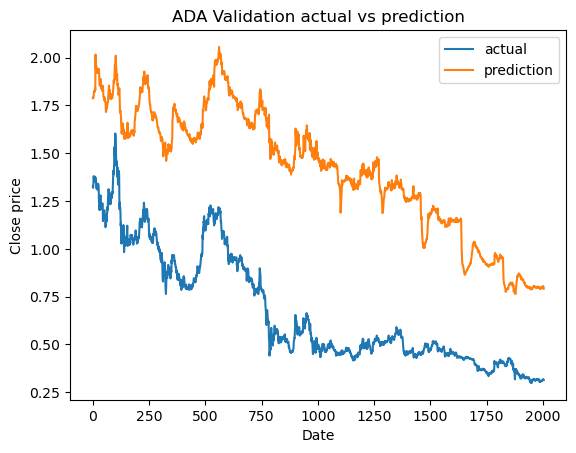



---------
Epoch 16, Train || MSE: 0.0457880, MAE: 0.1361410, R2: -98.8378398, RMSE: 0.1643696
Epoch 16, Evaluation || MSE: 0.4002056, MAE: 0.6124335, R2: -5155.0174481, RMSE: 0.6130335


---------
Epoch 17, Train || MSE: 0.0425510, MAE: 0.1341374, R2: -116.2153614, RMSE: 0.1639390
Epoch 17, Evaluation || MSE: 0.4018901, MAE: 0.6099697, R2: -5450.8935779, RMSE: 0.6105854


---------
Epoch 18, Train || MSE: 0.0429343, MAE: 0.1354066, R2: -109.6950920, RMSE: 0.1652873
Epoch 18, Evaluation || MSE: 0.3061628, MAE: 0.5095629, R2: -4859.2955477, RMSE: 0.5105208


---------
Epoch 19, Train || MSE: 0.0435791, MAE: 0.1357331, R2: -121.7838555, RMSE: 0.1663563
Epoch 19, Evaluation || MSE: 0.2727911, MAE: 0.4731853, R2: -4634.5221364, RMSE: 0.4743203


---------
Epoch 20, Train || MSE: 0.0426384, MAE: 0.1349703, R2: -129.3532230, RMSE: 0.1646335
Epoch 20, Evaluation || MSE: 0.3036656, MAE: 0.5064763, R2: -5401.9806146, RMSE: 0.5074184


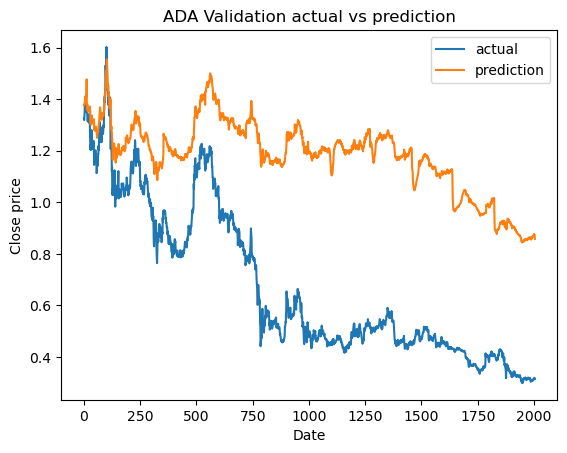



---------
Epoch 21, Train || MSE: 0.0459907, MAE: 0.1430685, R2: -139.2296918, RMSE: 0.1729337
Epoch 21, Evaluation || MSE: 0.2575065, MAE: 0.4570662, R2: -4925.5621211, RMSE: 0.4580959


---------
Epoch 22, Train || MSE: 0.0430532, MAE: 0.1418238, R2: -159.8012313, RMSE: 0.1710934
Epoch 22, Evaluation || MSE: 0.2636416, MAE: 0.4665983, R2: -4834.4514316, RMSE: 0.4676076


---------
Epoch 23, Train || MSE: 0.0392685, MAE: 0.1368660, R2: -144.1526183, RMSE: 0.1648027
Epoch 23, Evaluation || MSE: 0.3314557, MAE: 0.5352204, R2: -5907.4552696, RMSE: 0.5359637


---------
Epoch 24, Train || MSE: 0.0403378, MAE: 0.1347053, R2: -142.7892204, RMSE: 0.1641289
Epoch 24, Evaluation || MSE: 0.2148796, MAE: 0.4141955, R2: -3845.9715803, RMSE: 0.4153470


---------
Epoch 25, Train || MSE: 0.0369000, MAE: 0.1314425, R2: -156.0743944, RMSE: 0.1589925
Epoch 25, Evaluation || MSE: 0.2391296, MAE: 0.4401695, R2: -4437.7447170, RMSE: 0.4412200


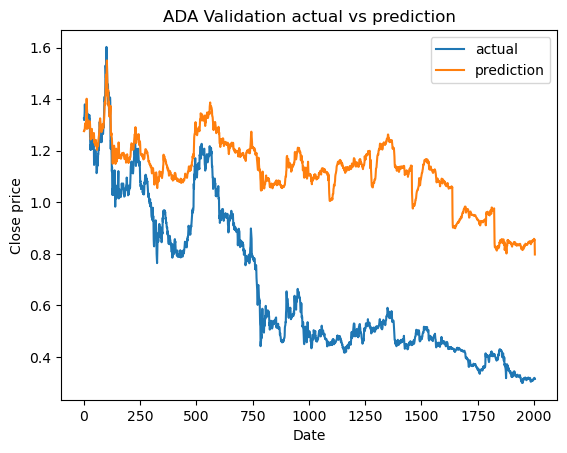



---------
Epoch 26, Train || MSE: 0.0384128, MAE: 0.1349603, R2: -135.5679373, RMSE: 0.1622144
Epoch 26, Evaluation || MSE: 0.2446360, MAE: 0.4438478, R2: -4737.7344228, RMSE: 0.4448838


---------
Epoch 27, Train || MSE: 0.0380944, MAE: 0.1345399, R2: -138.6623857, RMSE: 0.1632660
Epoch 27, Evaluation || MSE: 0.2531443, MAE: 0.4496853, R2: -5128.6009637, RMSE: 0.4507247


---------
Epoch 28, Train || MSE: 0.0392155, MAE: 0.1369634, R2: -161.3675499, RMSE: 0.1655002
Epoch 28, Evaluation || MSE: 0.2451920, MAE: 0.4376660, R2: -5157.0729419, RMSE: 0.4388362


---------
Epoch 29, Train || MSE: 0.0373303, MAE: 0.1326565, R2: -151.2940696, RMSE: 0.1621355
Epoch 29, Evaluation || MSE: 0.2297986, MAE: 0.4219828, R2: -4801.0025096, RMSE: 0.4232325


---------
Epoch 30, Train || MSE: 0.0353600, MAE: 0.1311080, R2: -143.7519426, RMSE: 0.1584225
Epoch 30, Evaluation || MSE: 0.2395190, MAE: 0.4375048, R2: -5030.3156395, RMSE: 0.4385798


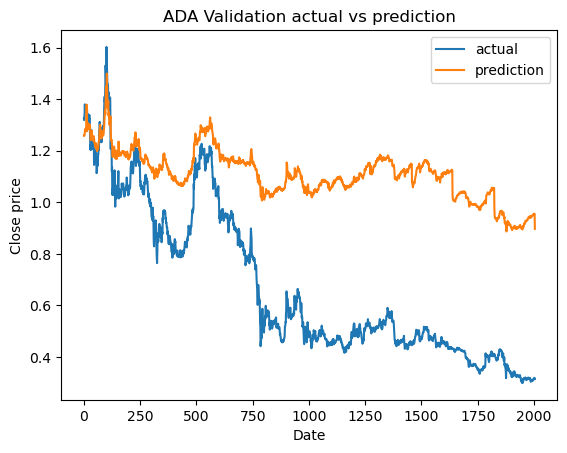

Training BNB coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 21967.2091671, MAE: 78.4825595, R2: -943.0275074, RMSE: 82.2384189
Epoch 1, Evaluation || MSE: 59846.7802386, MAE: 233.7920878, R2: -4956.8118963, RMSE: 233.9894931


---------
Epoch 2, Train || MSE: 33371.8273999, MAE: 113.3600077, R2: -173634.0715356, RMSE: 118.4327615
Epoch 2, Evaluation || MSE: 21717.5525947, MAE: 131.3368601, R2: -1920.4677545, RMSE: 131.8227263


---------
Epoch 3, Train || MSE: 28854.5850817, MAE: 103.0702104, R2: -154006.9674575, RMSE: 109.5470987
Epoch 3, Evaluation || MSE: 23573.8169598, MAE: 137.7922737, R2: -2076.7024958, RMSE: 138.2508765


---------
Epoch 4, Train || MSE: 24370.5366167, MAE: 92.7142386, R2: -129072.1077698, RMSE: 98.3908851
Epoch 4, Evaluation || MSE: 24381.5450498, MAE: 140.5811366, R2: -2141.0564638, RMSE: 141.0245832


---------
Epoch 5, Train || MSE: 9743.7082406, MAE: 57.9269683, R2: -38915.0200194, RMSE: 64.7881356
Epoch 5, Evaluation || MSE: 42514.4933102, MAE: 194.0779313, R2: -3584.8745174, RMSE:

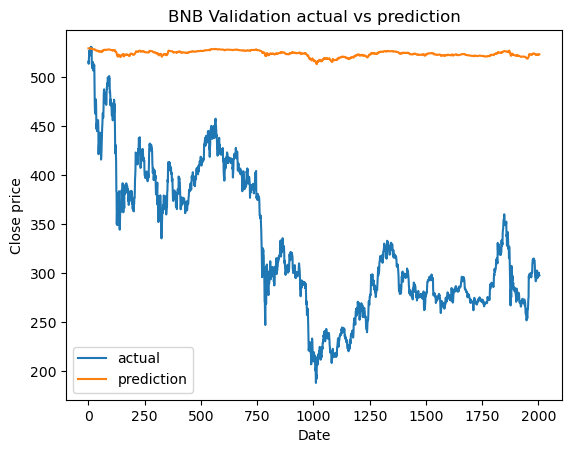



---------
Epoch 6, Train || MSE: 4887.8143511, MAE: 40.5070260, R2: -3878.2406541, RMSE: 47.7051427
Epoch 6, Evaluation || MSE: 47337.8688132, MAE: 209.1897488, R2: -3908.5239885, RMSE: 209.3415058


---------
Epoch 7, Train || MSE: 4026.8411202, MAE: 34.6622981, R2: -1575.0929800, RMSE: 41.5788993
Epoch 7, Evaluation || MSE: 32137.9714995, MAE: 168.9770582, R2: -2775.1703260, RMSE: 169.3649290


---------
Epoch 8, Train || MSE: 3884.4559355, MAE: 32.7013621, R2: -429.5276091, RMSE: 39.2474123
Epoch 8, Evaluation || MSE: 24843.8603622, MAE: 149.9321523, R2: -2119.4902445, RMSE: 150.0937924


---------
Epoch 9, Train || MSE: 3313.5071244, MAE: 31.1646011, R2: -558.9768553, RMSE: 37.5359398
Epoch 9, Evaluation || MSE: 18575.8615064, MAE: 128.6066341, R2: -1632.3028801, RMSE: 128.8075467


---------
Epoch 10, Train || MSE: 2926.9869672, MAE: 28.1019667, R2: -274.1058200, RMSE: 34.5167196
Epoch 10, Evaluation || MSE: 13653.6962736, MAE: 108.8722703, R2: -1227.4095784, RMSE: 109.1306426


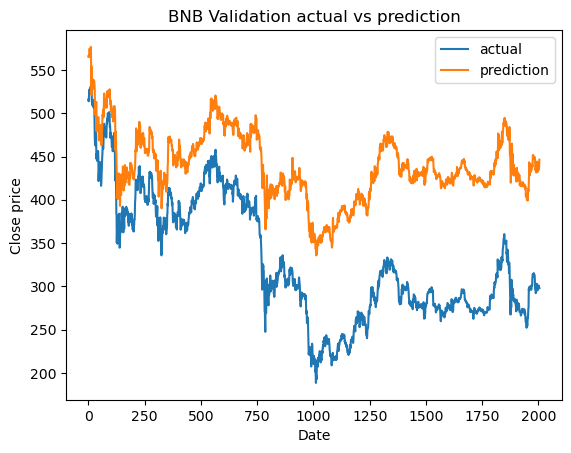



---------
Epoch 11, Train || MSE: 2746.1114281, MAE: 27.2228381, R2: -289.9193288, RMSE: 33.3339121
Epoch 11, Evaluation || MSE: 9884.1822258, MAE: 90.5500288, R2: -911.6553290, RMSE: 90.8855652


---------
Epoch 12, Train || MSE: 2829.9082209, MAE: 27.8365001, R2: -340.1294673, RMSE: 34.0246632
Epoch 12, Evaluation || MSE: 10605.9317070, MAE: 95.3404680, R2: -961.1438357, RMSE: 95.6222402


---------
Epoch 13, Train || MSE: 2871.7089444, MAE: 28.1595460, R2: -344.5726053, RMSE: 34.3660058
Epoch 13, Evaluation || MSE: 8857.0929747, MAE: 86.1427387, R2: -812.6130304, RMSE: 86.4782973


---------
Epoch 14, Train || MSE: 2885.4672713, MAE: 27.9762677, R2: -307.6788313, RMSE: 34.2884002
Epoch 14, Evaluation || MSE: 10887.0764712, MAE: 98.1304684, R2: -974.1335890, RMSE: 98.3947768


---------
Epoch 15, Train || MSE: 2631.6999527, MAE: 27.0463599, R2: -274.3856681, RMSE: 32.9477165
Epoch 15, Evaluation || MSE: 7047.0591943, MAE: 75.6901631, R2: -663.8889778, RMSE: 76.1251133


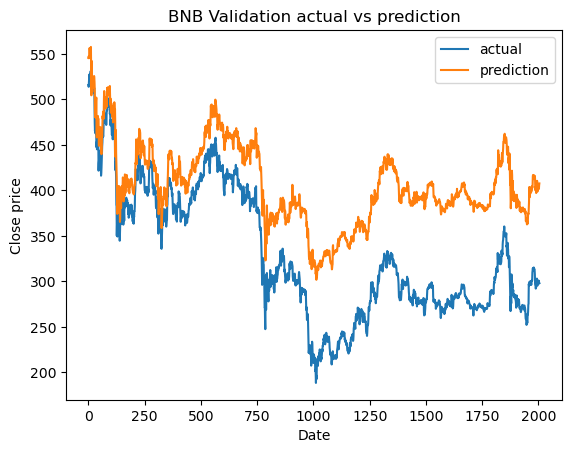



---------
Epoch 16, Train || MSE: 2728.9004813, MAE: 26.8727382, R2: -256.4999657, RMSE: 33.0883525
Epoch 16, Evaluation || MSE: 9719.7542066, MAE: 92.0660353, R2: -876.4391793, RMSE: 92.3359775


---------
Epoch 17, Train || MSE: 2803.9524578, MAE: 27.9605051, R2: -259.9534314, RMSE: 34.1202893
Epoch 17, Evaluation || MSE: 9186.1877364, MAE: 90.1604687, R2: -818.2729712, RMSE: 90.4515666


---------
Epoch 18, Train || MSE: 2780.8210666, MAE: 27.1490397, R2: -244.3184908, RMSE: 33.3528895
Epoch 18, Evaluation || MSE: 7913.7598533, MAE: 83.2156911, R2: -705.8080819, RMSE: 83.5354454


---------
Epoch 19, Train || MSE: 2772.1268817, MAE: 27.0396652, R2: -235.2147522, RMSE: 33.2415859
Epoch 19, Evaluation || MSE: 8142.9895087, MAE: 83.6629644, R2: -739.8946920, RMSE: 83.9798841


---------
Epoch 20, Train || MSE: 2689.7639296, MAE: 26.5204699, R2: -228.9665591, RMSE: 32.6795898
Epoch 20, Evaluation || MSE: 9079.0290988, MAE: 90.3513409, R2: -792.7648220, RMSE: 90.6646533


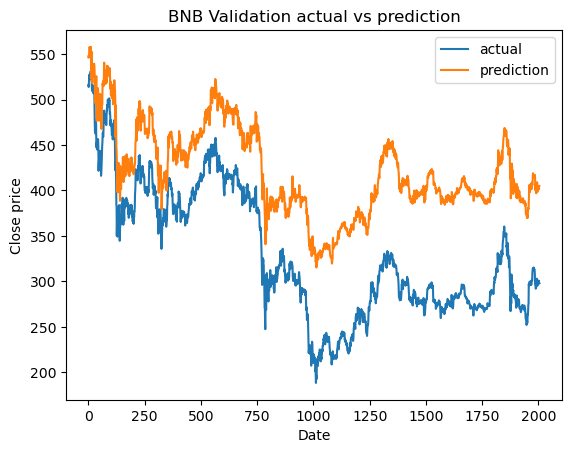



---------
Epoch 21, Train || MSE: 2603.1550818, MAE: 26.3786425, R2: -216.2244158, RMSE: 32.3319684
Epoch 21, Evaluation || MSE: 9765.6597842, MAE: 93.6291098, R2: -868.5464045, RMSE: 93.9115026


---------
Epoch 22, Train || MSE: 2852.7261022, MAE: 27.2536446, R2: -222.4093872, RMSE: 33.5944667
Epoch 22, Evaluation || MSE: 7742.6236064, MAE: 82.7287505, R2: -692.1171468, RMSE: 83.0992767


---------
Epoch 23, Train || MSE: 2568.5053290, MAE: 25.7665710, R2: -208.1474774, RMSE: 31.9230316
Epoch 23, Evaluation || MSE: 10368.0955714, MAE: 94.7654683, R2: -947.0571256, RMSE: 95.0207631


---------
Epoch 24, Train || MSE: 2664.1612187, MAE: 26.4513998, R2: -199.3406416, RMSE: 32.5795431
Epoch 24, Evaluation || MSE: 9356.4941503, MAE: 89.7218681, R2: -859.1615648, RMSE: 90.0399193


---------
Epoch 25, Train || MSE: 2708.1813981, MAE: 26.8074534, R2: -210.0953925, RMSE: 32.5591609
Epoch 25, Evaluation || MSE: 9526.0435278, MAE: 91.8944318, R2: -858.0354795, RMSE: 92.1713775


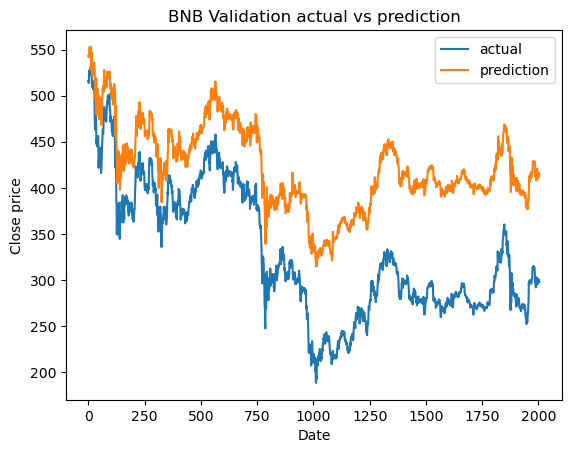



---------
Epoch 26, Train || MSE: 2889.4479133, MAE: 27.3388258, R2: -212.5331275, RMSE: 33.4537260
Epoch 26, Evaluation || MSE: 8242.0137273, MAE: 83.3239341, R2: -763.7707765, RMSE: 83.6147422


---------
Epoch 27, Train || MSE: 2827.2307888, MAE: 27.3477146, R2: -231.8183757, RMSE: 33.7009940
Epoch 27, Evaluation || MSE: 8394.4184759, MAE: 85.8182803, R2: -770.8264889, RMSE: 86.1219968


---------
Epoch 28, Train || MSE: 3007.8283454, MAE: 28.2529038, R2: -219.3874247, RMSE: 34.5327136
Epoch 28, Evaluation || MSE: 12364.6580200, MAE: 107.5078475, R2: -1059.3319379, RMSE: 107.7310803


---------
Epoch 29, Train || MSE: 2635.0011284, MAE: 26.7249757, R2: -252.8272777, RMSE: 32.8548703
Epoch 29, Evaluation || MSE: 6429.1549932, MAE: 74.3285287, R2: -605.7477499, RMSE: 74.7108874


---------
Epoch 30, Train || MSE: 2991.7127911, MAE: 28.6167831, R2: -219.1261814, RMSE: 34.8591378
Epoch 30, Evaluation || MSE: 6788.4532582, MAE: 75.2717085, R2: -645.6243996, RMSE: 75.5704415


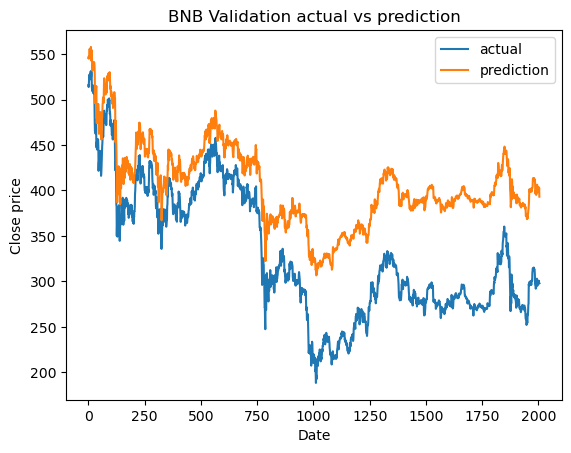

Training BTC coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 992985611.8095238, MAE: 24971.7346787, R2: -8495.2855018, RMSE: 24981.2813692
Epoch 1, Evaluation || MSE: 812047660.3174603, MAE: 26670.9275794, R2: -8219.0969712, RMSE: 26678.2959837


---------
Epoch 2, Train || MSE: 691383746.2135416, MAE: 18752.7065531, R2: -2278.5902070, RMSE: 18871.1042104
Epoch 2, Evaluation || MSE: 273789039.8705357, MAE: 13160.4662020, R2: -1641.7303841, RMSE: 13195.2498699


---------
Epoch 3, Train || MSE: 330806123.1445312, MAE: 12495.5096199, R2: -1772.1207324, RMSE: 12839.8112003
Epoch 3, Evaluation || MSE: 112462382.3015873, MAE: 9863.0452358, R2: -3722.9799989, RMSE: 9895.7705233


---------
Epoch 4, Train || MSE: 214700649.4676339, MAE: 10988.3869680, R2: -5813.8990786, RMSE: 11524.3170751
Epoch 4, Evaluation || MSE: 263304106.1990327, MAE: 13410.2732786, R2: -9760.2670404, RMSE: 13466.9961783


---------
Epoch 5, Train || MSE: 118760914.3883929, MAE: 7770.5578793, R2: -4652.1871353, RMSE: 8478.1014521
Epoch 5, Evaluat

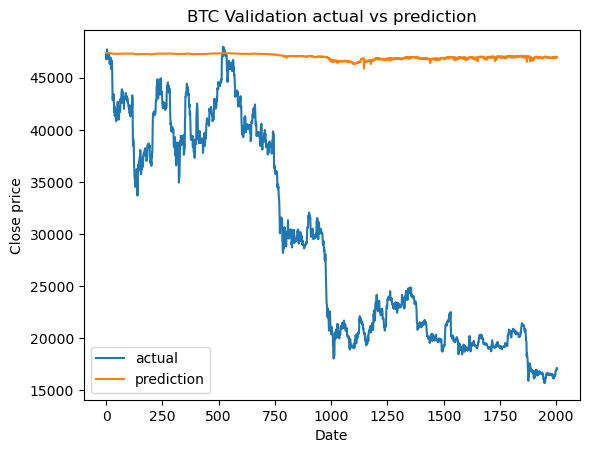



---------
Epoch 6, Train || MSE: 60404188.4334077, MAE: 5396.0575438, R2: -586.5874581, RMSE: 6171.5869580
Epoch 6, Evaluation || MSE: 513611827.0793651, MAE: 20614.1939562, R2: -17078.9259090, RMSE: 20633.3311845


---------
Epoch 7, Train || MSE: 61210516.6062128, MAE: 5297.8578286, R2: -541.9948195, RMSE: 6116.0471589
Epoch 7, Evaluation || MSE: 458883968.7380952, MAE: 19663.2702714, R2: -15359.8294024, RMSE: 19684.5182892


---------
Epoch 8, Train || MSE: 52682748.7754836, MAE: 4792.4809588, R2: -428.4531126, RMSE: 5613.6722639
Epoch 8, Evaluation || MSE: 390468959.6507937, MAE: 18487.4404607, R2: -12998.2883139, RMSE: 18517.1095378


---------
Epoch 9, Train || MSE: 42179739.4507068, MAE: 4266.1085979, R2: -380.0860755, RMSE: 5085.4664597
Epoch 9, Evaluation || MSE: 252713367.0634921, MAE: 15154.5178881, R2: -8432.4308131, RMSE: 15204.2435787


---------
Epoch 10, Train || MSE: 32687393.7520461, MAE: 3774.1399433, R2: -330.8890444, RMSE: 4578.1854528
Epoch 10, Evaluation || MSE

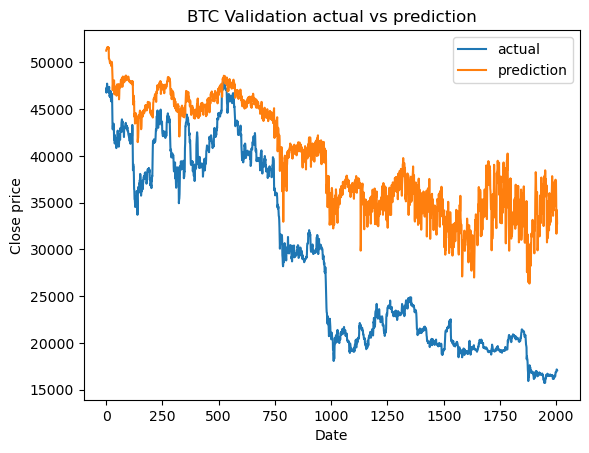



---------
Epoch 11, Train || MSE: 34579518.7300967, MAE: 3851.9754704, R2: -315.2730506, RMSE: 4653.0949433
Epoch 11, Evaluation || MSE: 176975455.4285714, MAE: 12566.1640257, R2: -5967.5476706, RMSE: 12624.1425103


---------
Epoch 12, Train || MSE: 30508846.5541295, MAE: 3675.1875690, R2: -335.1069041, RMSE: 4460.9428006
Epoch 12, Evaluation || MSE: 73592111.1011905, MAE: 7871.9611158, R2: -2786.5351255, RMSE: 7964.3679122


---------
Epoch 13, Train || MSE: 29561525.5610119, MAE: 3625.0680522, R2: -324.2804819, RMSE: 4376.5206468
Epoch 13, Evaluation || MSE: 64237918.5257936, MAE: 7341.0725718, R2: -2480.5242264, RMSE: 7433.9557466


---------
Epoch 14, Train || MSE: 29261110.2317708, MAE: 3622.4921644, R2: -320.7695304, RMSE: 4399.4124342
Epoch 14, Evaluation || MSE: 84858920.7619048, MAE: 8788.5526917, R2: -2864.6521075, RMSE: 8859.2456229


---------
Epoch 15, Train || MSE: 28330231.6640625, MAE: 3566.4682305, R2: -333.1123117, RMSE: 4353.0669508
Epoch 15, Evaluation || MSE: 71

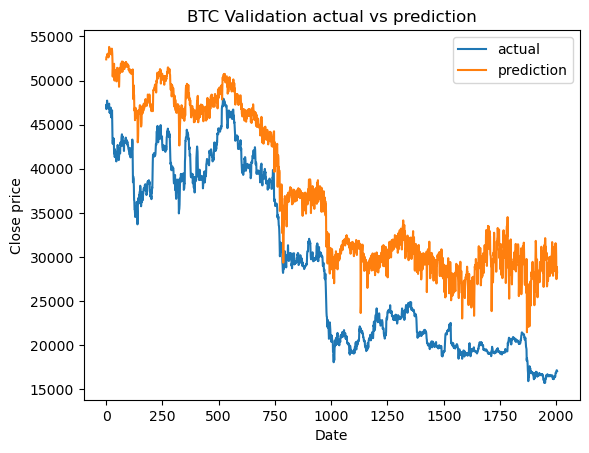



---------
Epoch 16, Train || MSE: 25245699.2129836, MAE: 3392.8224329, R2: -326.6974729, RMSE: 4145.8886761
Epoch 16, Evaluation || MSE: 56709562.8412698, MAE: 7211.3957888, R2: -1811.4831616, RMSE: 7270.4947083


---------
Epoch 17, Train || MSE: 26319620.2325149, MAE: 3474.4762586, R2: -318.7040366, RMSE: 4201.3611734
Epoch 17, Evaluation || MSE: 95193598.9761905, MAE: 9442.6819022, R2: -2937.7548147, RMSE: 9477.0591460


---------
Epoch 18, Train || MSE: 27074777.6026786, MAE: 3451.6736617, R2: -302.4060967, RMSE: 4195.5458163
Epoch 18, Evaluation || MSE: 93175529.6507937, MAE: 9416.5975012, R2: -2665.9725879, RMSE: 9448.0594812


---------
Epoch 19, Train || MSE: 25623281.9711682, MAE: 3381.7451864, R2: -309.4767181, RMSE: 4159.7433165
Epoch 19, Evaluation || MSE: 93009111.0158730, MAE: 9433.4682423, R2: -2327.0944487, RMSE: 9467.4862777


---------
Epoch 20, Train || MSE: 26522495.7213542, MAE: 3427.8873402, R2: -307.5942287, RMSE: 4201.4893294
Epoch 20, Evaluation || MSE: 67861

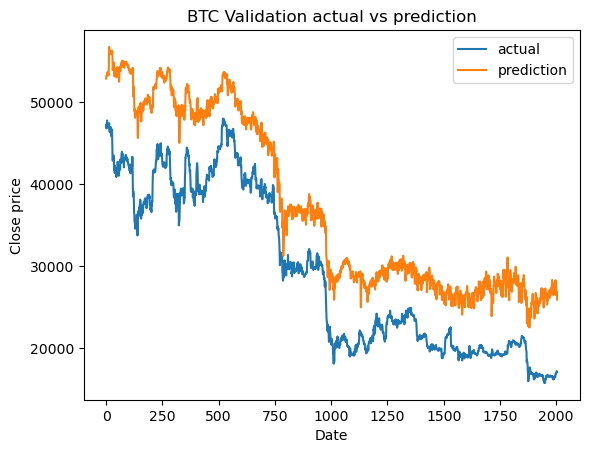



---------
Epoch 21, Train || MSE: 25386421.8675595, MAE: 3329.4012684, R2: -280.7285967, RMSE: 4092.5222519
Epoch 21, Evaluation || MSE: 82040588.4920635, MAE: 8824.5926843, R2: -1790.1459817, RMSE: 8852.8629557


---------
Epoch 22, Train || MSE: 25381664.5265997, MAE: 3294.4150300, R2: -284.7817760, RMSE: 4076.1609760
Epoch 22, Evaluation || MSE: 77584928.2222222, MAE: 8480.8640951, R2: -1390.8416142, RMSE: 8506.8179525


---------
Epoch 23, Train || MSE: 26876008.3488653, MAE: 3423.4194430, R2: -306.4800308, RMSE: 4186.4691115
Epoch 23, Evaluation || MSE: 117132440.5396825, MAE: 10694.1415357, R2: -2730.8348292, RMSE: 10711.3192429


---------
Epoch 24, Train || MSE: 25505125.7896205, MAE: 3329.6862037, R2: -286.8452557, RMSE: 4106.6352087
Epoch 24, Evaluation || MSE: 107367246.6349206, MAE: 10143.7403351, R2: -1987.6989945, RMSE: 10160.1619195


---------
Epoch 25, Train || MSE: 24569923.3937872, MAE: 3287.5617979, R2: -325.3777138, RMSE: 4040.3751408
Epoch 25, Evaluation || MSE:

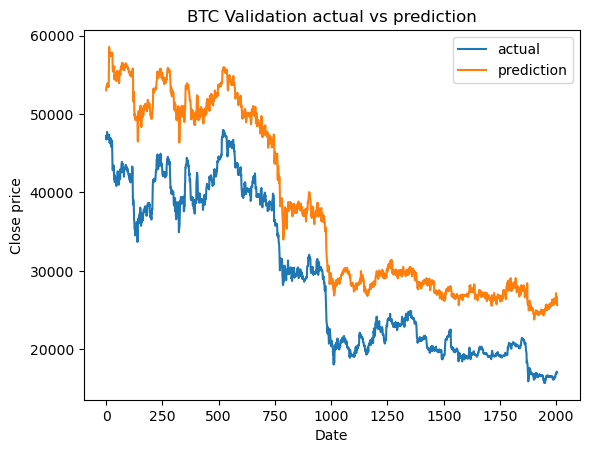



---------
Epoch 26, Train || MSE: 24314241.8735119, MAE: 3308.4536856, R2: -313.1325746, RMSE: 4059.6922974
Epoch 26, Evaluation || MSE: 76943669.6031746, MAE: 8260.3272957, R2: -997.6379636, RMSE: 8281.0015695


---------
Epoch 27, Train || MSE: 23774163.7447917, MAE: 3196.3234489, R2: -293.5587104, RMSE: 3950.7122370
Epoch 27, Evaluation || MSE: 91781283.0793651, MAE: 9452.2336503, R2: -1801.8394774, RMSE: 9477.7175060


---------
Epoch 28, Train || MSE: 22721247.3559338, MAE: 3137.7748945, R2: -301.4053275, RMSE: 3884.6338080
Epoch 28, Evaluation || MSE: 99528424.5396825, MAE: 9721.4329272, R2: -1529.5428399, RMSE: 9745.1590828


---------
Epoch 29, Train || MSE: 23665413.3145461, MAE: 3229.4441746, R2: -359.4225082, RMSE: 3950.2646161
Epoch 29, Evaluation || MSE: 77649426.1170635, MAE: 8612.9477355, R2: -1612.8016159, RMSE: 8674.5916060


---------
Epoch 30, Train || MSE: 23902094.3575149, MAE: 3204.3455008, R2: -326.8002157, RMSE: 3962.1647858
Epoch 30, Evaluation || MSE: 626385

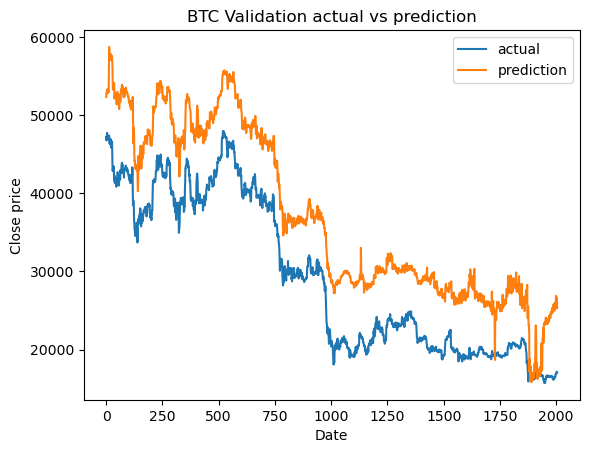

Training DASH coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 7107.7064475, MAE: 59.0467347, R2: -1212.4756437, RMSE: 62.8394514
Epoch 1, Evaluation || MSE: 8185.1210511, MAE: 82.8601060, R2: -9943.1131401, RMSE: 84.4174698


---------
Epoch 2, Train || MSE: 4071.8414834, MAE: 46.1782707, R2: -693.0405898, RMSE: 51.2410106
Epoch 2, Evaluation || MSE: 11920.4187564, MAE: 104.2280232, R2: -21694.5777393, RMSE: 104.2832665


---------
Epoch 3, Train || MSE: 4282.1422132, MAE: 46.4170797, R2: -719.4720762, RMSE: 51.1458767
Epoch 3, Evaluation || MSE: 11768.2465418, MAE: 103.4894185, R2: -21452.7661817, RMSE: 103.5455429


---------
Epoch 4, Train || MSE: 4279.7171693, MAE: 46.0589630, R2: -713.6639212, RMSE: 50.7955848
Epoch 4, Evaluation || MSE: 11251.5923171, MAE: 100.9678769, R2: -20610.5719485, RMSE: 101.0266756


---------
Epoch 5, Train || MSE: 4335.0814627, MAE: 46.4085049, R2: -750.7886962, RMSE: 51.0488639
Epoch 5, Evaluation || MSE: 11436.8215245, MAE: 101.8899112, R2: -20905.4493716, RMSE: 101.9476217


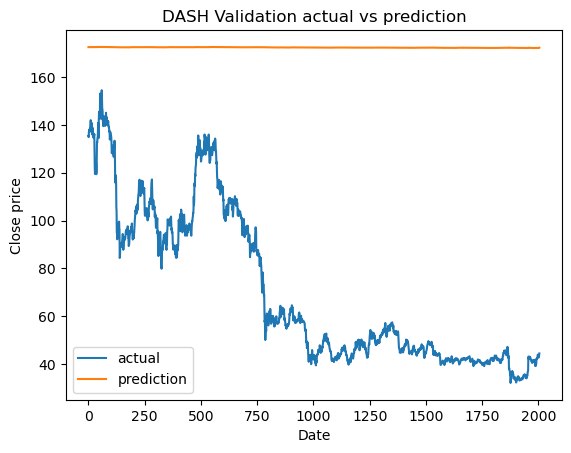



---------
Epoch 6, Train || MSE: 4286.8375901, MAE: 46.2554037, R2: -781.8334460, RMSE: 50.9231578
Epoch 6, Evaluation || MSE: 11514.4188775, MAE: 102.3085187, R2: -21002.7655720, RMSE: 102.3654890


---------
Epoch 7, Train || MSE: 4268.6433776, MAE: 46.0873489, R2: -739.8506107, RMSE: 50.8022565
Epoch 7, Evaluation || MSE: 11481.5657465, MAE: 102.2656863, R2: -20888.2126021, RMSE: 102.3217621


---------
Epoch 8, Train || MSE: 4003.7321239, MAE: 44.5915837, R2: -645.7922616, RMSE: 49.3128334
Epoch 8, Evaluation || MSE: 11475.6040034, MAE: 102.2868606, R2: -20834.8599369, RMSE: 102.3425438


---------
Epoch 9, Train || MSE: 4041.9227354, MAE: 44.8067056, R2: -634.8347125, RMSE: 49.4545086
Epoch 9, Evaluation || MSE: 11581.3578632, MAE: 102.7742147, R2: -21050.6198197, RMSE: 102.8293749


---------
Epoch 10, Train || MSE: 3935.0067254, MAE: 44.4783356, R2: -711.5340502, RMSE: 49.3526569
Epoch 10, Evaluation || MSE: 11265.3269358, MAE: 101.4066788, R2: -20369.1348454, RMSE: 101.462660

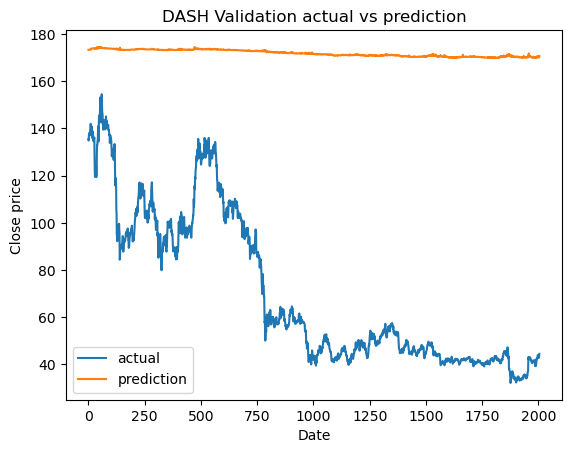



---------
Epoch 11, Train || MSE: 3808.2886648, MAE: 43.5193633, R2: -659.1288921, RMSE: 48.3096355
Epoch 11, Evaluation || MSE: 11548.9817175, MAE: 102.7760235, R2: -20914.8370874, RMSE: 102.8292504


---------
Epoch 12, Train || MSE: 3674.5204740, MAE: 42.9229557, R2: -688.5994051, RMSE: 47.9309750
Epoch 12, Evaluation || MSE: 11135.4511157, MAE: 101.5080408, R2: -19812.9788670, RMSE: 101.5582059


---------
Epoch 13, Train || MSE: 3299.3890014, MAE: 40.8623490, R2: -632.4504336, RMSE: 45.7775199
Epoch 13, Evaluation || MSE: 10974.9005398, MAE: 100.7511546, R2: -19657.6391663, RMSE: 100.8025848


---------
Epoch 14, Train || MSE: 2920.5925651, MAE: 38.7714629, R2: -587.9671852, RMSE: 43.7401521
Epoch 14, Evaluation || MSE: 11010.4626581, MAE: 101.3273203, R2: -19499.1328988, RMSE: 101.3792040


---------
Epoch 15, Train || MSE: 2439.9608237, MAE: 35.2107824, R2: -512.1577258, RMSE: 40.2284379
Epoch 15, Evaluation || MSE: 8905.6917046, MAE: 90.9932072, R2: -15883.8787145, RMSE: 91.0

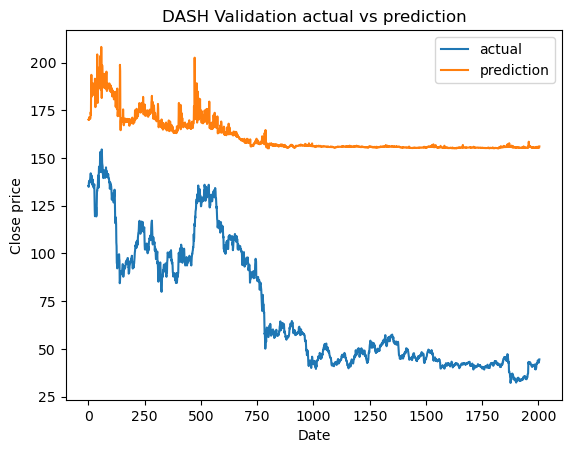



---------
Epoch 16, Train || MSE: 2174.3745177, MAE: 33.0037890, R2: -446.0626887, RMSE: 38.1670388
Epoch 16, Evaluation || MSE: 8040.6479841, MAE: 87.2219493, R2: -13755.9468715, RMSE: 87.2991060


---------
Epoch 17, Train || MSE: 1662.2066473, MAE: 28.7609600, R2: -371.9465870, RMSE: 34.2077882
Epoch 17, Evaluation || MSE: 6211.0616261, MAE: 77.4196482, R2: -9954.4589038, RMSE: 77.5214270


---------
Epoch 18, Train || MSE: 1360.4576395, MAE: 26.6714110, R2: -305.5374067, RMSE: 32.0501427
Epoch 18, Evaluation || MSE: 4848.7092256, MAE: 68.7629504, R2: -6831.2167058, RMSE: 68.8880415


---------
Epoch 19, Train || MSE: 1110.1483828, MAE: 23.6547391, R2: -264.5359591, RMSE: 29.0402120
Epoch 19, Evaluation || MSE: 4245.1443520, MAE: 64.4425389, R2: -6314.2290365, RMSE: 64.5269410


---------
Epoch 20, Train || MSE: 1046.6195414, MAE: 22.8888724, R2: -236.0194234, RMSE: 28.1869298
Epoch 20, Evaluation || MSE: 3658.3989713, MAE: 59.9943685, R2: -5264.2211680, RMSE: 60.0697239


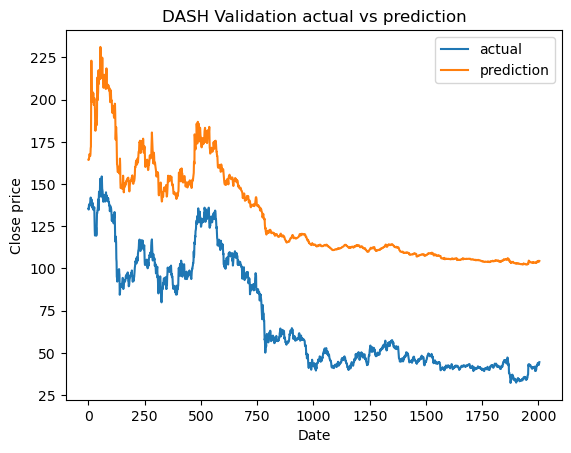



---------
Epoch 21, Train || MSE: 980.9641861, MAE: 21.8215844, R2: -204.1360870, RMSE: 27.0876944
Epoch 21, Evaluation || MSE: 3106.7872237, MAE: 54.9746934, R2: -4704.5572761, RMSE: 55.0532774


---------
Epoch 22, Train || MSE: 1018.5966319, MAE: 21.6978373, R2: -190.7276135, RMSE: 27.2870993
Epoch 22, Evaluation || MSE: 2666.7750244, MAE: 50.9202139, R2: -3839.3108982, RMSE: 50.9842372


---------
Epoch 23, Train || MSE: 976.3287255, MAE: 20.8906781, R2: -155.6843577, RMSE: 26.3135955
Epoch 23, Evaluation || MSE: 1828.8352608, MAE: 41.8566540, R2: -2601.4077971, RMSE: 41.9502780


---------
Epoch 24, Train || MSE: 1008.4876787, MAE: 21.5058297, R2: -165.3632712, RMSE: 26.8934382
Epoch 24, Evaluation || MSE: 1626.3003241, MAE: 37.5004660, R2: -2733.8258562, RMSE: 37.6664848


---------
Epoch 25, Train || MSE: 1049.1232060, MAE: 21.5816899, R2: -152.6969296, RMSE: 26.9464589
Epoch 25, Evaluation || MSE: 1465.6217295, MAE: 33.6402541, R2: -2864.8275894, RMSE: 33.8619138


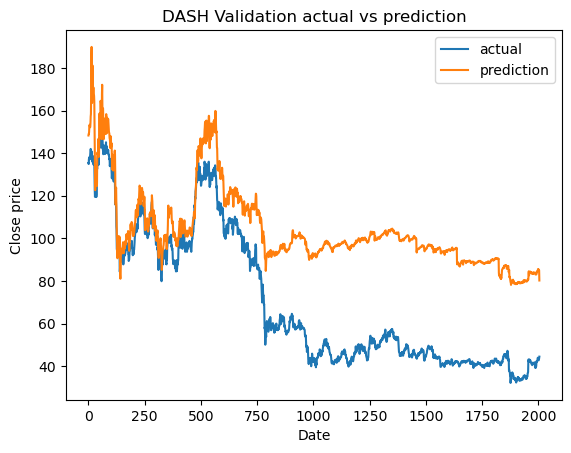



---------
Epoch 26, Train || MSE: 1054.2003568, MAE: 22.0256532, R2: -150.6900801, RMSE: 27.2007956
Epoch 26, Evaluation || MSE: 1475.3607632, MAE: 32.6996777, R2: -2973.0458299, RMSE: 32.9054001


---------
Epoch 27, Train || MSE: 914.9965771, MAE: 20.5894429, R2: -151.9601870, RMSE: 25.8772550
Epoch 27, Evaluation || MSE: 1292.3191211, MAE: 30.7900068, R2: -2747.2114106, RMSE: 31.0028788


---------
Epoch 28, Train || MSE: 939.6683624, MAE: 20.9744211, R2: -152.9896598, RMSE: 26.2017840
Epoch 28, Evaluation || MSE: 809.8935002, MAE: 23.2924315, R2: -1880.5765367, RMSE: 23.5305032


---------
Epoch 29, Train || MSE: 889.8486412, MAE: 20.1435559, R2: -147.4505351, RMSE: 25.3356853
Epoch 29, Evaluation || MSE: 524.2347092, MAE: 19.1155647, R2: -1228.9958688, RMSE: 19.3374788


---------
Epoch 30, Train || MSE: 899.0817365, MAE: 20.4120920, R2: -150.0246738, RMSE: 25.5731059
Epoch 30, Evaluation || MSE: 483.9013839, MAE: 18.1702384, R2: -1154.3645096, RMSE: 18.4391625


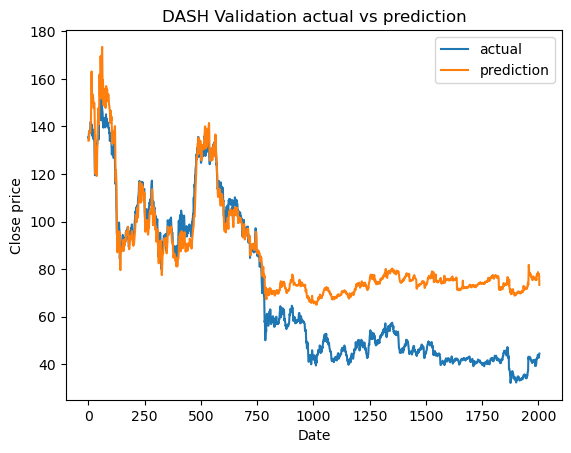

Training ETH coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 1754845.5594330, MAE: 881.1226115, R2: -1990.8190300, RMSE: 889.5927257
Epoch 1, Evaluation || MSE: 1143702.0455167, MAE: 912.4173057, R2: -2833.9462300, RMSE: 917.2448649


---------
Epoch 2, Train || MSE: 285316.2597787, MAE: 304.4361709, R2: -342.7118846, RMSE: 348.3788086
Epoch 2, Evaluation || MSE: 4678644.6179936, MAE: 2025.1037028, R2: -10042.8542712, RMSE: 2026.5987638


---------
Epoch 3, Train || MSE: 463717.1289408, MAE: 385.4979045, R2: -7535.9880117, RMSE: 441.7771213
Epoch 3, Evaluation || MSE: 4289406.1579241, MAE: 1945.9406729, R2: -9130.7864182, RMSE: 1947.3926016


---------
Epoch 4, Train || MSE: 254703.2251885, MAE: 292.3303769, R2: -844.3422063, RMSE: 342.5426051
Epoch 4, Evaluation || MSE: 2544447.0727927, MAE: 1518.9845138, R2: -5277.9642493, RMSE: 1520.3384213


---------
Epoch 5, Train || MSE: 171233.1978996, MAE: 239.7715041, R2: -578.5196160, RMSE: 288.4955869
Epoch 5, Evaluation || MSE: 1539894.0620040, MAE: 1167.7821607, R2

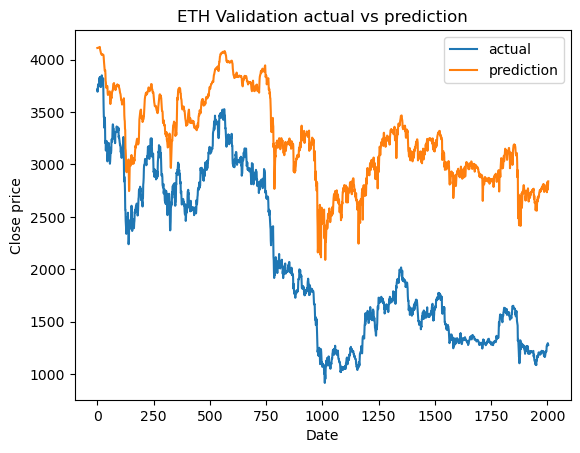



---------
Epoch 6, Train || MSE: 135626.2959033, MAE: 206.4158719, R2: -326.7563881, RMSE: 254.0694593
Epoch 6, Evaluation || MSE: 992724.2088914, MAE: 916.8996858, R2: -2206.8081539, RMSE: 920.5170335


---------
Epoch 7, Train || MSE: 131185.5827674, MAE: 198.6479871, R2: -234.3417734, RMSE: 243.3858694
Epoch 7, Evaluation || MSE: 792545.3271097, MAE: 783.6189008, R2: -1876.9926840, RMSE: 787.6710249


---------
Epoch 8, Train || MSE: 121475.9661346, MAE: 195.4458884, R2: -211.9783461, RMSE: 238.3360320
Epoch 8, Evaluation || MSE: 947703.6494451, MAE: 863.0338699, R2: -2230.9635599, RMSE: 866.4704342


---------
Epoch 9, Train || MSE: 132584.4738064, MAE: 203.0363748, R2: -238.8249922, RMSE: 249.3699901
Epoch 9, Evaluation || MSE: 700700.1211635, MAE: 699.9128812, R2: -1756.5298759, RMSE: 704.7707109


---------
Epoch 10, Train || MSE: 129924.4567752, MAE: 201.1102086, R2: -225.3199602, RMSE: 245.4808399
Epoch 10, Evaluation || MSE: 981489.9304005, MAE: 868.4320329, R2: -2416.31140

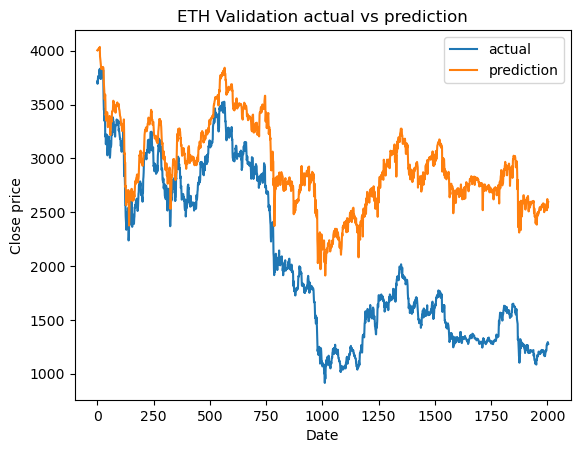



---------
Epoch 11, Train || MSE: 129159.6464522, MAE: 199.6310446, R2: -228.5498345, RMSE: 244.1971896
Epoch 11, Evaluation || MSE: 629489.5735382, MAE: 650.8612924, R2: -1668.8749287, RMSE: 655.8685228


---------
Epoch 12, Train || MSE: 120497.9657797, MAE: 193.8974535, R2: -210.0475295, RMSE: 238.4701888
Epoch 12, Evaluation || MSE: 736577.4922166, MAE: 709.6224155, R2: -1957.4258454, RMSE: 714.2710499


---------
Epoch 13, Train || MSE: 132243.3271923, MAE: 204.2625866, R2: -205.3426711, RMSE: 247.6977911
Epoch 13, Evaluation || MSE: 448926.7302603, MAE: 553.3320942, R2: -1246.4940479, RMSE: 558.7787099


---------
Epoch 14, Train || MSE: 129316.6532635, MAE: 202.8443666, R2: -210.3991277, RMSE: 246.4216467
Epoch 14, Evaluation || MSE: 466891.0852855, MAE: 566.7584135, R2: -1270.1952746, RMSE: 571.7085574


---------
Epoch 15, Train || MSE: 134055.6814013, MAE: 206.2831518, R2: -206.2032702, RMSE: 250.1129554
Epoch 15, Evaluation || MSE: 334853.2692406, MAE: 503.0897315, R2: -92

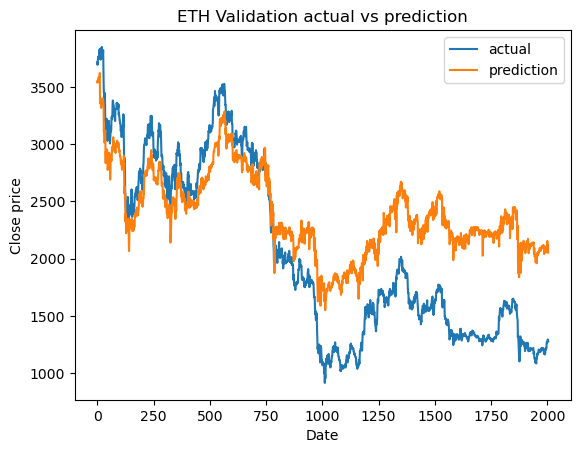



---------
Epoch 16, Train || MSE: 121628.8749935, MAE: 198.5007194, R2: -206.7555446, RMSE: 243.0693670
Epoch 16, Evaluation || MSE: 283613.3262620, MAE: 463.0730410, R2: -787.5134269, RMSE: 467.1423194


---------
Epoch 17, Train || MSE: 113561.0346630, MAE: 191.7296332, R2: -212.4173107, RMSE: 234.1748303
Epoch 17, Evaluation || MSE: 278350.4887676, MAE: 453.2016734, R2: -797.7395369, RMSE: 457.1907975


---------
Epoch 18, Train || MSE: 114604.3637494, MAE: 189.8480440, R2: -217.1958913, RMSE: 235.1660374
Epoch 18, Evaluation || MSE: 215086.0139451, MAE: 420.7270014, R2: -580.4197019, RMSE: 424.2448322


---------
Epoch 19, Train || MSE: 126651.7293532, MAE: 195.7136378, R2: -213.9658206, RMSE: 242.1213577
Epoch 19, Evaluation || MSE: 216473.1743338, MAE: 414.4375100, R2: -603.8458195, RMSE: 417.8581674


---------
Epoch 20, Train || MSE: 105117.0331554, MAE: 186.1716004, R2: -205.1846258, RMSE: 227.0376489
Epoch 20, Evaluation || MSE: 162997.6286287, MAE: 367.0416499, R2: -443.87

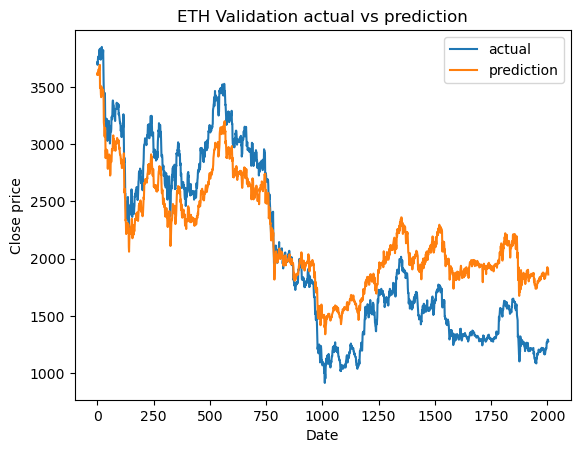



---------
Epoch 21, Train || MSE: 113848.8186527, MAE: 189.4849876, R2: -212.4361520, RMSE: 233.1227849
Epoch 21, Evaluation || MSE: 154220.2425363, MAE: 357.9165568, R2: -422.5648919, RMSE: 361.3765607


---------
Epoch 22, Train || MSE: 107468.8202823, MAE: 185.7931720, R2: -195.2936494, RMSE: 227.1329723
Epoch 22, Evaluation || MSE: 180820.4575728, MAE: 375.9019887, R2: -525.9996727, RMSE: 379.6640874


---------
Epoch 23, Train || MSE: 121059.4868788, MAE: 193.6903159, R2: -218.3561962, RMSE: 239.5652882
Epoch 23, Evaluation || MSE: 124614.7143080, MAE: 310.7894069, R2: -377.1710932, RMSE: 315.4155754


---------
Epoch 24, Train || MSE: 103038.0329389, MAE: 182.0415141, R2: -185.0394905, RMSE: 224.8838409
Epoch 24, Evaluation || MSE: 166435.7983360, MAE: 363.4691129, R2: -475.4633904, RMSE: 367.2837649


---------
Epoch 25, Train || MSE: 115256.7377276, MAE: 195.5199271, R2: -229.8843008, RMSE: 236.8385167
Epoch 25, Evaluation || MSE: 143523.8292740, MAE: 321.8415217, R2: -439.51

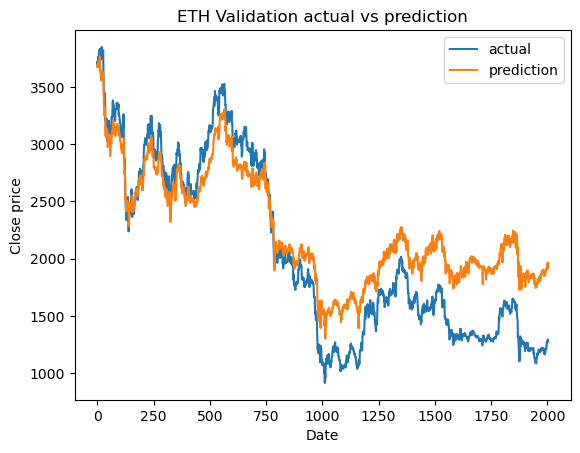



---------
Epoch 26, Train || MSE: 116448.8387432, MAE: 193.9260582, R2: -192.9880587, RMSE: 236.7135681
Epoch 26, Evaluation || MSE: 104441.0224081, MAE: 260.0303329, R2: -336.4062531, RMSE: 265.8494617


---------
Epoch 27, Train || MSE: 112026.8755030, MAE: 187.3051431, R2: -208.6715430, RMSE: 230.1361433
Epoch 27, Evaluation || MSE: 112870.8039938, MAE: 270.1006291, R2: -366.4339636, RMSE: 275.4432910


---------
Epoch 28, Train || MSE: 110994.4928102, MAE: 187.2364786, R2: -201.6100986, RMSE: 229.4769591
Epoch 28, Evaluation || MSE: 132358.7168630, MAE: 295.7038465, R2: -416.3686863, RMSE: 301.4745321


---------
Epoch 29, Train || MSE: 113020.9708336, MAE: 186.2373997, R2: -196.6158366, RMSE: 229.6446168
Epoch 29, Evaluation || MSE: 55097.7203783, MAE: 190.4771652, R2: -179.8305342, RMSE: 196.3564774


---------
Epoch 30, Train || MSE: 108522.7771802, MAE: 184.5300231, R2: -211.3697089, RMSE: 227.6361608
Epoch 30, Evaluation || MSE: 67582.5381254, MAE: 208.8953116, R2: -217.7161

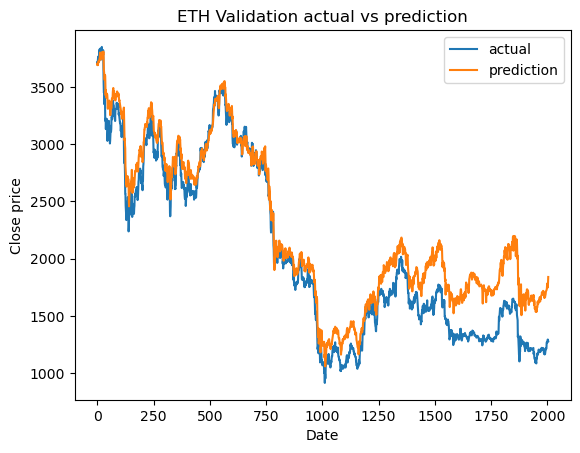

Training LINK coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 37.6909501, MAE: 4.0740633, R2: -303.7326457, RMSE: 4.5834964
Epoch 1, Evaluation || MSE: 103.6014011, MAE: 9.3715696, R2: -4656.2446057, RMSE: 9.3994507


---------
Epoch 2, Train || MSE: 43.1709659, MAE: 4.5191673, R2: -2331.5155948, RMSE: 5.0180100
Epoch 2, Evaluation || MSE: 206.3397762, MAE: 13.5515850, R2: -8845.2005944, RMSE: 13.5697354


---------
Epoch 3, Train || MSE: 69.4312975, MAE: 6.1970948, R2: -5365.2388529, RMSE: 6.6447721
Epoch 3, Evaluation || MSE: 255.7860276, MAE: 15.1839645, R2: -10780.8247805, RMSE: 15.2004062


---------
Epoch 4, Train || MSE: 90.0268520, MAE: 7.3264832, R2: -9444.4406667, RMSE: 7.6754986
Epoch 4, Evaluation || MSE: 244.5783855, MAE: 14.8347904, R2: -10324.1834959, RMSE: 14.8507698


---------
Epoch 5, Train || MSE: 89.8078555, MAE: 7.4004057, R2: -11148.5908625, RMSE: 7.7612511
Epoch 5, Evaluation || MSE: 234.5145834, MAE: 14.5694626, R2: -9789.5141396, RMSE: 14.5858511


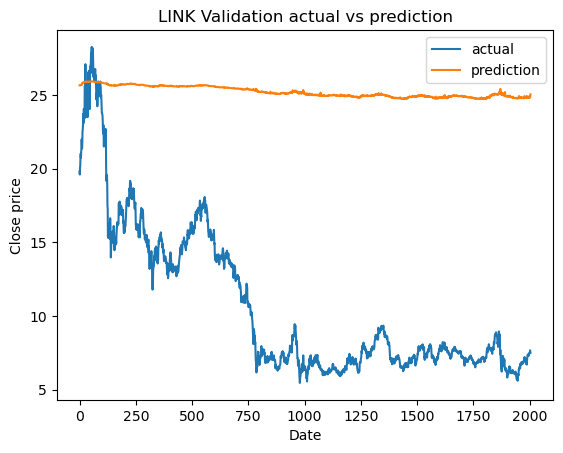



---------
Epoch 6, Train || MSE: 58.6415711, MAE: 5.9034647, R2: -11085.0711439, RMSE: 6.3613428
Epoch 6, Evaluation || MSE: 209.1754336, MAE: 13.7347709, R2: -8790.5265552, RMSE: 13.7516380


---------
Epoch 7, Train || MSE: 58.8821319, MAE: 5.8662260, R2: -6885.0672526, RMSE: 6.2738841
Epoch 7, Evaluation || MSE: 205.0249164, MAE: 13.7271472, R2: -8401.8329419, RMSE: 13.7407418


---------
Epoch 8, Train || MSE: 46.2752652, MAE: 5.0482262, R2: -5298.4877923, RMSE: 5.5607438
Epoch 8, Evaluation || MSE: 165.4691116, MAE: 12.3941799, R2: -6690.2837762, RMSE: 12.4070679


---------
Epoch 9, Train || MSE: 30.0757528, MAE: 3.9304485, R2: -3077.2371091, RMSE: 4.3906692
Epoch 9, Evaluation || MSE: 121.6390881, MAE: 10.6382998, R2: -4856.1245299, RMSE: 10.6528547


---------
Epoch 10, Train || MSE: 20.3171386, MAE: 3.0412281, R2: -623.1358206, RMSE: 3.5354811
Epoch 10, Evaluation || MSE: 89.7279470, MAE: 9.2461169, R2: -3456.9089017, RMSE: 9.2582630


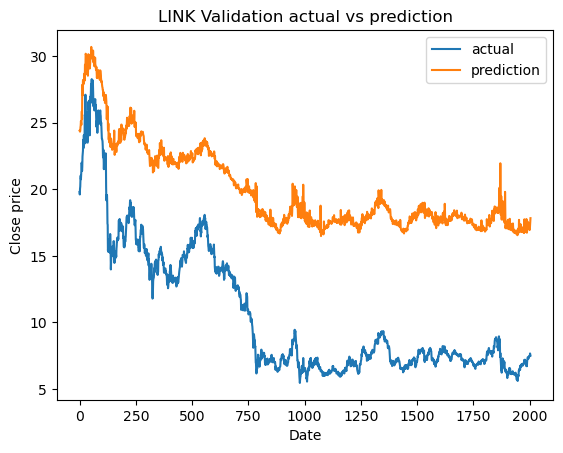



---------
Epoch 11, Train || MSE: 14.7994685, MAE: 2.4853386, R2: -208.3381194, RMSE: 2.9509836
Epoch 11, Evaluation || MSE: 58.6761183, MAE: 7.5266106, R2: -2222.5697404, RMSE: 7.5380419


---------
Epoch 12, Train || MSE: 12.6468393, MAE: 2.2513769, R2: -120.7786797, RMSE: 2.7262394
Epoch 12, Evaluation || MSE: 43.8527102, MAE: 6.4132341, R2: -1802.8179214, RMSE: 6.4237366


---------
Epoch 13, Train || MSE: 11.4281864, MAE: 2.1133652, R2: -91.7837947, RMSE: 2.5833955
Epoch 13, Evaluation || MSE: 47.9661753, MAE: 6.8366941, R2: -1785.8252951, RMSE: 6.8448690


---------
Epoch 14, Train || MSE: 10.6900035, MAE: 2.0267267, R2: -90.7653642, RMSE: 2.5087757
Epoch 14, Evaluation || MSE: 32.2507845, MAE: 5.6156696, R2: -1191.2403085, RMSE: 5.6268351


---------
Epoch 15, Train || MSE: 9.3675673, MAE: 1.9115013, R2: -74.9426723, RMSE: 2.3504313
Epoch 15, Evaluation || MSE: 18.2480503, MAE: 4.1569196, R2: -683.2128508, RMSE: 4.1775233


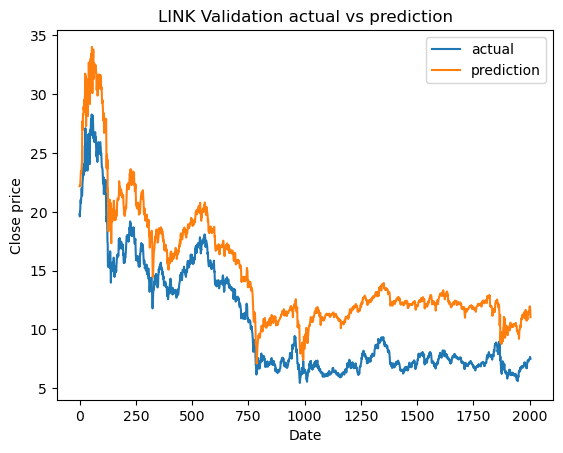



---------
Epoch 16, Train || MSE: 8.8437739, MAE: 1.8602188, R2: -73.5848805, RMSE: 2.2982045
Epoch 16, Evaluation || MSE: 9.8424965, MAE: 2.8432582, R2: -415.5424446, RMSE: 2.8776331


---------
Epoch 17, Train || MSE: 8.5480461, MAE: 1.8312821, R2: -70.5457270, RMSE: 2.2614931
Epoch 17, Evaluation || MSE: 7.0215368, MAE: 2.3029564, R2: -330.0096164, RMSE: 2.3438663


---------
Epoch 18, Train || MSE: 8.7872001, MAE: 1.8807140, R2: -70.0427105, RMSE: 2.2914639
Epoch 18, Evaluation || MSE: 6.3201332, MAE: 2.1213656, R2: -317.9769502, RMSE: 2.1629725


---------
Epoch 19, Train || MSE: 8.7604476, MAE: 1.8274148, R2: -75.1221472, RMSE: 2.2550123
Epoch 19, Evaluation || MSE: 5.5017637, MAE: 2.0240438, R2: -254.3560099, RMSE: 2.0624670


---------
Epoch 20, Train || MSE: 8.2005855, MAE: 1.7836287, R2: -67.8258275, RMSE: 2.1948001
Epoch 20, Evaluation || MSE: 3.6864643, MAE: 1.6430386, R2: -165.0581277, RMSE: 1.6818953


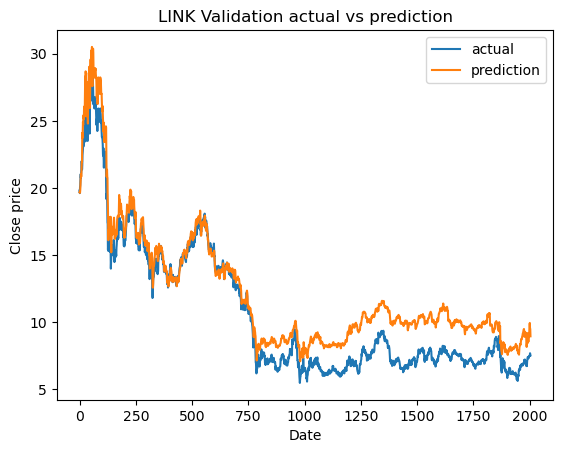



---------
Epoch 21, Train || MSE: 8.2556256, MAE: 1.8118175, R2: -65.3216175, RMSE: 2.2172722
Epoch 21, Evaluation || MSE: 4.4339963, MAE: 1.7697072, R2: -211.9073894, RMSE: 1.8138281


---------
Epoch 22, Train || MSE: 8.0495517, MAE: 1.7814258, R2: -62.7081480, RMSE: 2.1840477
Epoch 22, Evaluation || MSE: 2.0428809, MAE: 1.2337887, R2: -90.1546651, RMSE: 1.2775637


---------
Epoch 23, Train || MSE: 8.3106539, MAE: 1.7760301, R2: -52.5539935, RMSE: 2.1779048
Epoch 23, Evaluation || MSE: 1.5258083, MAE: 1.1159902, R2: -59.7318385, RMSE: 1.1580843


---------
Epoch 24, Train || MSE: 8.4147861, MAE: 1.7645953, R2: -49.1957095, RMSE: 2.1773757
Epoch 24, Evaluation || MSE: 3.6151505, MAE: 1.6591373, R2: -166.0280498, RMSE: 1.7007559


---------
Epoch 25, Train || MSE: 8.1792574, MAE: 1.7474334, R2: -60.3019685, RMSE: 2.1637916
Epoch 25, Evaluation || MSE: 2.5917339, MAE: 1.3898600, R2: -118.8500514, RMSE: 1.4340777


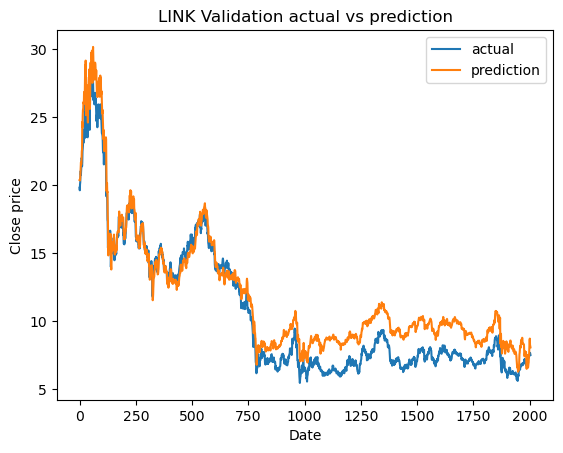



---------
Epoch 26, Train || MSE: 8.1509085, MAE: 1.7378716, R2: -48.3338413, RMSE: 2.1501345
Epoch 26, Evaluation || MSE: 1.9309652, MAE: 1.2001603, R2: -87.7678265, RMSE: 1.2425557


---------
Epoch 27, Train || MSE: 7.9359120, MAE: 1.7277424, R2: -46.2467511, RMSE: 2.1297808
Epoch 27, Evaluation || MSE: 2.0312293, MAE: 1.2422580, R2: -93.3349137, RMSE: 1.2800803


---------
Epoch 28, Train || MSE: 7.8559036, MAE: 1.6903787, R2: -38.7805443, RMSE: 2.1104962
Epoch 28, Evaluation || MSE: 4.7756752, MAE: 1.9179152, R2: -220.1216228, RMSE: 1.9563876


---------
Epoch 29, Train || MSE: 8.7043097, MAE: 1.7890911, R2: -46.0717946, RMSE: 2.1989411
Epoch 29, Evaluation || MSE: 2.6860046, MAE: 1.3746910, R2: -133.1858104, RMSE: 1.4102397


---------
Epoch 30, Train || MSE: 7.4561479, MAE: 1.6710198, R2: -40.5685580, RMSE: 2.0473482
Epoch 30, Evaluation || MSE: 4.8865513, MAE: 2.0273420, R2: -196.3182342, RMSE: 2.0648273


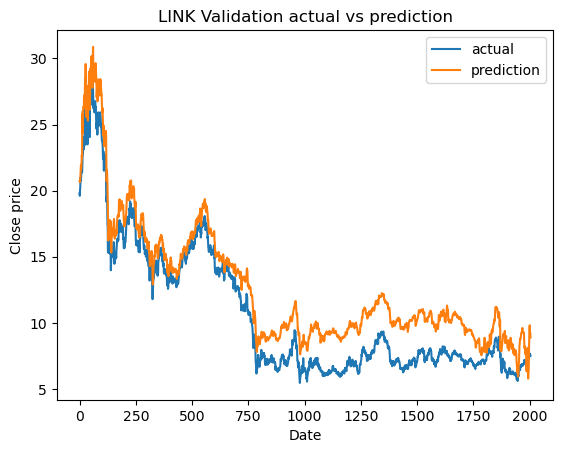

Training LTC coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 8475.5098440, MAE: 57.4071091, R2: -870.1067670, RMSE: 59.7133523
Epoch 1, Evaluation || MSE: 9997.1213238, MAE: 95.4256850, R2: -11268.0665358, RMSE: 95.4754437


---------
Epoch 2, Train || MSE: 1662.2679599, MAE: 26.5931149, R2: -210.9830011, RMSE: 30.2995198
Epoch 2, Evaluation || MSE: 11913.0192309, MAE: 105.0588058, R2: -13150.2271776, RMSE: 105.1010763


---------
Epoch 3, Train || MSE: 1814.7626996, MAE: 28.1973779, R2: -224.5230718, RMSE: 31.8449458
Epoch 3, Evaluation || MSE: 11858.9986795, MAE: 104.7866777, R2: -13104.3812882, RMSE: 104.8292150


---------
Epoch 4, Train || MSE: 1741.3407672, MAE: 27.6325936, R2: -214.5599693, RMSE: 31.4775336
Epoch 4, Evaluation || MSE: 11851.8288177, MAE: 104.7441987, R2: -13104.9359864, RMSE: 104.7868589


---------
Epoch 5, Train || MSE: 1691.1671039, MAE: 27.3875647, R2: -207.8642251, RMSE: 31.0346205
Epoch 5, Evaluation || MSE: 11919.5374058, MAE: 105.1295569, R2: -13174.0408956, RMSE: 105.1711690


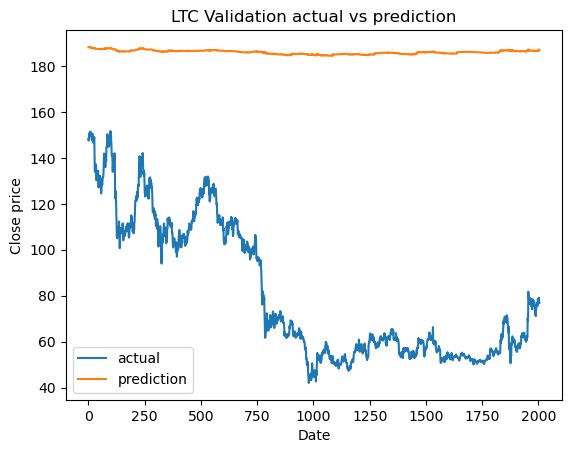



---------
Epoch 6, Train || MSE: 1635.6769323, MAE: 27.0935042, R2: -210.0520233, RMSE: 30.7542765
Epoch 6, Evaluation || MSE: 11178.5325308, MAE: 101.5960751, R2: -12424.7147965, RMSE: 101.6391749


---------
Epoch 7, Train || MSE: 1568.7547653, MAE: 26.0212586, R2: -195.6047871, RMSE: 29.8987163
Epoch 7, Evaluation || MSE: 10330.2440961, MAE: 97.4011620, R2: -11573.0879839, RMSE: 97.4463728


---------
Epoch 8, Train || MSE: 1391.0714383, MAE: 24.0567055, R2: -165.5873383, RMSE: 27.8756230
Epoch 8, Evaluation || MSE: 10142.5029452, MAE: 96.5564699, R2: -11350.5738266, RMSE: 96.6004618


---------
Epoch 9, Train || MSE: 1285.2591152, MAE: 23.2874770, R2: -164.5540723, RMSE: 27.0709294
Epoch 9, Evaluation || MSE: 8675.8907025, MAE: 88.8204772, R2: -9852.4061278, RMSE: 88.8681052


---------
Epoch 10, Train || MSE: 1119.3497854, MAE: 21.8869030, R2: -164.9409696, RMSE: 25.8833334
Epoch 10, Evaluation || MSE: 7496.3533969, MAE: 82.4577680, R2: -8614.1283174, RMSE: 82.5047865


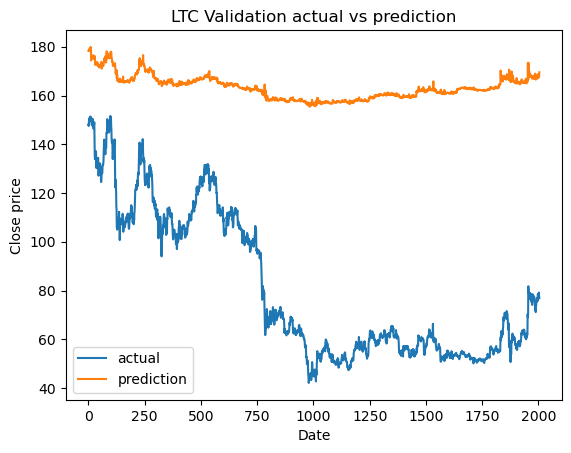



---------
Epoch 11, Train || MSE: 949.1748095, MAE: 20.4809879, R2: -159.9900771, RMSE: 24.1433930
Epoch 11, Evaluation || MSE: 5393.4897524, MAE: 69.1036837, R2: -6364.7136752, RMSE: 69.1571704


---------
Epoch 12, Train || MSE: 764.6403534, MAE: 18.6469847, R2: -140.4161639, RMSE: 22.2357295
Epoch 12, Evaluation || MSE: 3864.9634380, MAE: 57.6354490, R2: -4680.6654274, RMSE: 57.6978867


---------
Epoch 13, Train || MSE: 632.0037996, MAE: 16.9215401, R2: -120.1234307, RMSE: 20.3960212
Epoch 13, Evaluation || MSE: 3180.4797062, MAE: 52.3738223, R2: -3861.6366668, RMSE: 52.4293801


---------
Epoch 14, Train || MSE: 624.7370553, MAE: 17.0886695, R2: -132.0161951, RMSE: 20.6135300
Epoch 14, Evaluation || MSE: 2123.6147990, MAE: 41.9965553, R2: -2642.0923578, RMSE: 42.0680979


---------
Epoch 15, Train || MSE: 519.3258130, MAE: 15.2239060, R2: -103.7793197, RMSE: 18.6065460
Epoch 15, Evaluation || MSE: 1546.3884421, MAE: 36.2766601, R2: -1878.9823628, RMSE: 36.3458785


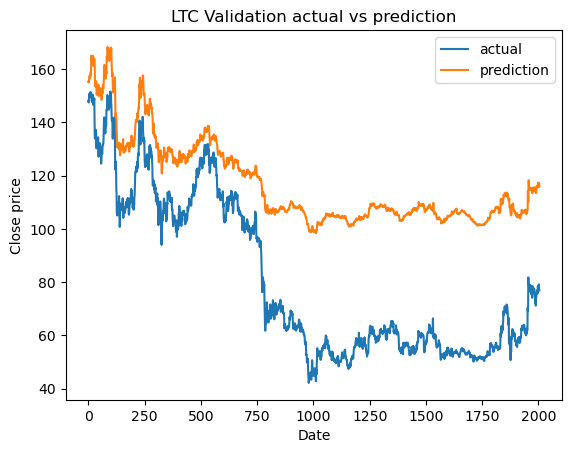



---------
Epoch 16, Train || MSE: 519.7978873, MAE: 15.0732582, R2: -94.3792051, RMSE: 18.6060330
Epoch 16, Evaluation || MSE: 1102.8584801, MAE: 30.9876528, R2: -1305.7437593, RMSE: 31.0570228


---------
Epoch 17, Train || MSE: 485.2677568, MAE: 14.7373030, R2: -88.5656087, RMSE: 18.0833425
Epoch 17, Evaluation || MSE: 821.8446763, MAE: 26.8930373, R2: -950.2186093, RMSE: 26.9716922


---------
Epoch 18, Train || MSE: 493.7668484, MAE: 14.7707783, R2: -91.2286914, RMSE: 18.1705459
Epoch 18, Evaluation || MSE: 873.3540757, MAE: 27.4618308, R2: -1059.3920318, RMSE: 27.5331801


---------
Epoch 19, Train || MSE: 512.2528355, MAE: 14.9619181, R2: -91.0330926, RMSE: 18.3550719
Epoch 19, Evaluation || MSE: 466.2850751, MAE: 18.9209803, R2: -604.8717024, RMSE: 19.0654767


---------
Epoch 20, Train || MSE: 483.1526109, MAE: 14.6283395, R2: -87.8438729, RMSE: 17.8750365
Epoch 20, Evaluation || MSE: 437.0434596, MAE: 17.9856394, R2: -576.1093413, RMSE: 18.1519730


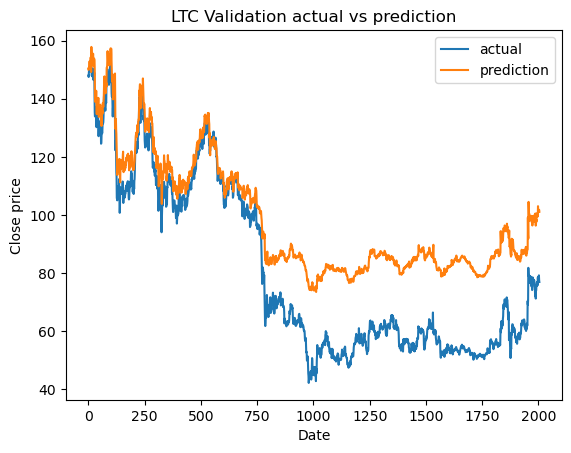



---------
Epoch 21, Train || MSE: 495.3529119, MAE: 14.6197296, R2: -88.2848065, RMSE: 18.0089694
Epoch 21, Evaluation || MSE: 488.3370668, MAE: 19.7327253, R2: -636.0410579, RMSE: 19.8535674


---------
Epoch 22, Train || MSE: 472.7415403, MAE: 14.4328196, R2: -82.9407941, RMSE: 17.7026510
Epoch 22, Evaluation || MSE: 439.3558882, MAE: 18.4741085, R2: -576.2841805, RMSE: 18.6145659


---------
Epoch 23, Train || MSE: 479.0231866, MAE: 14.4488328, R2: -87.7262615, RMSE: 17.6472713
Epoch 23, Evaluation || MSE: 578.6143394, MAE: 21.2565290, R2: -764.5262450, RMSE: 21.3774880


---------
Epoch 24, Train || MSE: 510.8553031, MAE: 14.9276993, R2: -89.5652291, RMSE: 18.4213297
Epoch 24, Evaluation || MSE: 461.7216798, MAE: 18.7773884, R2: -630.3330790, RMSE: 18.9132973


---------
Epoch 25, Train || MSE: 489.9149013, MAE: 14.4562109, R2: -84.7120800, RMSE: 17.7449897
Epoch 25, Evaluation || MSE: 337.9545976, MAE: 15.2579823, R2: -479.8501063, RMSE: 15.4460733


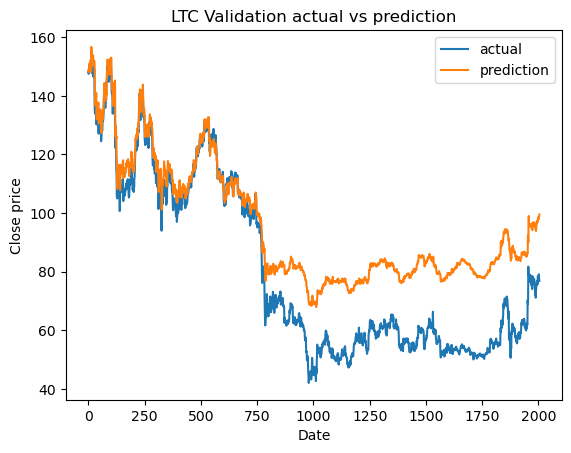



---------
Epoch 26, Train || MSE: 471.7066191, MAE: 14.2409349, R2: -82.4853089, RMSE: 17.5594337
Epoch 26, Evaluation || MSE: 188.5724033, MAE: 12.9027613, R2: -200.4916906, RMSE: 13.0406230


---------
Epoch 27, Train || MSE: 480.3434862, MAE: 14.3137278, R2: -84.2644661, RMSE: 17.7256935
Epoch 27, Evaluation || MSE: 476.1463241, MAE: 19.8536069, R2: -595.4900175, RMSE: 19.9652437


---------
Epoch 28, Train || MSE: 438.8144894, MAE: 13.7628089, R2: -73.9573160, RMSE: 16.9367224
Epoch 28, Evaluation || MSE: 288.3321558, MAE: 16.0741797, R2: -329.9594385, RMSE: 16.1802391


---------
Epoch 29, Train || MSE: 475.0127480, MAE: 14.0159629, R2: -71.9671435, RMSE: 17.2928499
Epoch 29, Evaluation || MSE: 529.0221852, MAE: 21.7770340, R2: -605.3941619, RMSE: 21.8585383


---------
Epoch 30, Train || MSE: 466.1352978, MAE: 14.2005047, R2: -76.0728022, RMSE: 17.3770068
Epoch 30, Evaluation || MSE: 562.0753219, MAE: 22.6382164, R2: -630.6806205, RMSE: 22.7128062


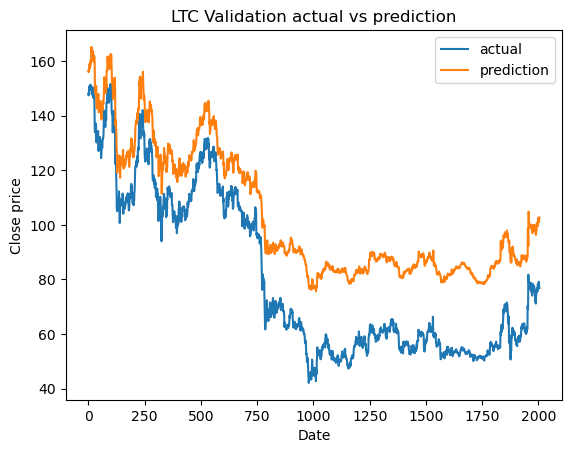

Training XRP coin...:   0%|          | 0/30 [00:00<?, ?it/s]


---------
Epoch 1, Train || MSE: 0.0716689, MAE: 0.1868266, R2: -831.4012174, RMSE: 0.2141405
Epoch 1, Evaluation || MSE: 0.0729403, MAE: 0.2311960, R2: -1955.9676499, RMSE: 0.2323088


---------
Epoch 2, Train || MSE: 0.0525241, MAE: 0.1533782, R2: -367.7222600, RMSE: 0.1787616
Epoch 2, Evaluation || MSE: 0.1366192, MAE: 0.3394118, R2: -3436.7736931, RMSE: 0.3399778


---------
Epoch 3, Train || MSE: 0.0515530, MAE: 0.1487604, R2: -344.1176012, RMSE: 0.1709613
Epoch 3, Evaluation || MSE: 0.1266582, MAE: 0.3256929, R2: -3188.5925112, RMSE: 0.3262456


---------
Epoch 4, Train || MSE: 0.0439469, MAE: 0.1354866, R2: -251.1131209, RMSE: 0.1562844
Epoch 4, Evaluation || MSE: 0.1262989, MAE: 0.3294047, R2: -3117.6052390, RMSE: 0.3298546


---------
Epoch 5, Train || MSE: 0.0298186, MAE: 0.1073545, R2: -121.8821761, RMSE: 0.1259873
Epoch 5, Evaluation || MSE: 0.0980366, MAE: 0.2889988, R2: -2438.4762579, RMSE: 0.2894582


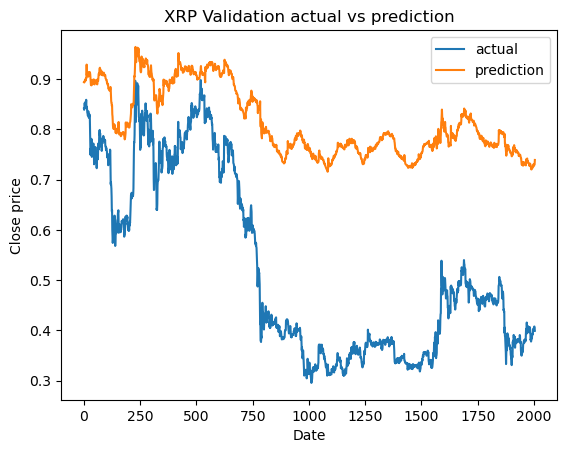



---------
Epoch 6, Train || MSE: 0.0264178, MAE: 0.0996334, R2: -110.8108011, RMSE: 0.1179916
Epoch 6, Evaluation || MSE: 0.0649510, MAE: 0.2263824, R2: -1684.1172313, RMSE: 0.2271078


---------
Epoch 7, Train || MSE: 0.0200566, MAE: 0.0837053, R2: -72.5155710, RMSE: 0.1004139
Epoch 7, Evaluation || MSE: 0.0577304, MAE: 0.2073044, R2: -1534.2765011, RMSE: 0.2081726


---------
Epoch 8, Train || MSE: 0.0175762, MAE: 0.0785404, R2: -60.2934732, RMSE: 0.0928708
Epoch 8, Evaluation || MSE: 0.0466487, MAE: 0.1796393, R2: -1270.2210562, RMSE: 0.1806635


---------
Epoch 9, Train || MSE: 0.0153616, MAE: 0.0735253, R2: -47.7551030, RMSE: 0.0860604
Epoch 9, Evaluation || MSE: 0.0390722, MAE: 0.1640207, R2: -1067.6226547, RMSE: 0.1650867


---------
Epoch 10, Train || MSE: 0.0148229, MAE: 0.0701994, R2: -44.9003584, RMSE: 0.0823854
Epoch 10, Evaluation || MSE: 0.0398077, MAE: 0.1661093, R2: -1085.9193385, RMSE: 0.1671574


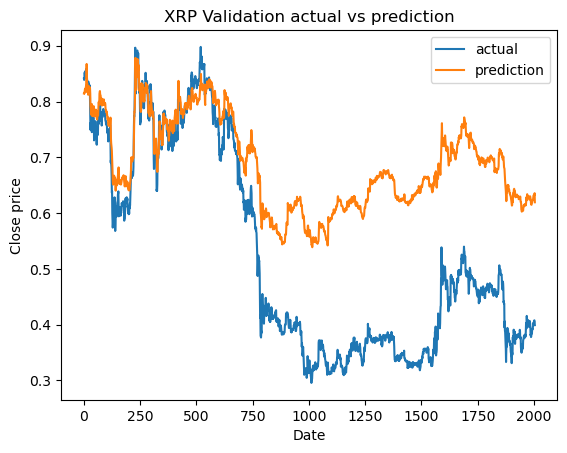



---------
Epoch 11, Train || MSE: 0.0138224, MAE: 0.0696704, R2: -49.7362970, RMSE: 0.0811891
Epoch 11, Evaluation || MSE: 0.0335189, MAE: 0.1512647, R2: -928.5590472, RMSE: 0.1523622


---------
Epoch 12, Train || MSE: 0.0131988, MAE: 0.0705739, R2: -54.5836477, RMSE: 0.0818772
Epoch 12, Evaluation || MSE: 0.0278018, MAE: 0.1375766, R2: -759.4677967, RMSE: 0.1387317


---------
Epoch 13, Train || MSE: 0.0135048, MAE: 0.0699781, R2: -56.7347221, RMSE: 0.0813562
Epoch 13, Evaluation || MSE: 0.0263459, MAE: 0.1349198, R2: -717.2710800, RMSE: 0.1359874


---------
Epoch 14, Train || MSE: 0.0137118, MAE: 0.0714613, R2: -55.9333600, RMSE: 0.0838285
Epoch 14, Evaluation || MSE: 0.0225921, MAE: 0.1249706, R2: -617.7189973, RMSE: 0.1261039


---------
Epoch 15, Train || MSE: 0.0107545, MAE: 0.0652212, R2: -50.3004121, RMSE: 0.0766852
Epoch 15, Evaluation || MSE: 0.0157757, MAE: 0.1062159, R2: -421.3856494, RMSE: 0.1073887


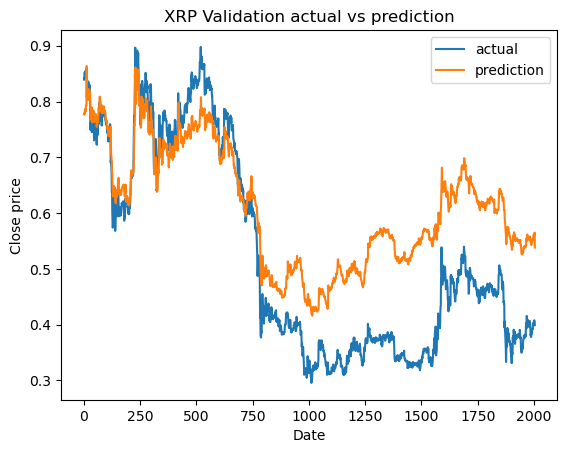



---------
Epoch 16, Train || MSE: 0.0117315, MAE: 0.0684935, R2: -59.7426411, RMSE: 0.0799439
Epoch 16, Evaluation || MSE: 0.0161333, MAE: 0.1086908, R2: -435.0969948, RMSE: 0.1098144


---------
Epoch 17, Train || MSE: 0.0123284, MAE: 0.0677629, R2: -52.3727892, RMSE: 0.0795940
Epoch 17, Evaluation || MSE: 0.0139070, MAE: 0.1003081, R2: -358.4034518, RMSE: 0.1014559


---------
Epoch 18, Train || MSE: 0.0128636, MAE: 0.0700135, R2: -56.7202704, RMSE: 0.0813838
Epoch 18, Evaluation || MSE: 0.0132534, MAE: 0.0999489, R2: -347.3226785, RMSE: 0.1009818


---------
Epoch 19, Train || MSE: 0.0114600, MAE: 0.0651201, R2: -48.7050381, RMSE: 0.0765068
Epoch 19, Evaluation || MSE: 0.0091956, MAE: 0.0830378, R2: -241.2300365, RMSE: 0.0842200


---------
Epoch 20, Train || MSE: 0.0112547, MAE: 0.0647987, R2: -55.4841486, RMSE: 0.0772362
Epoch 20, Evaluation || MSE: 0.0077091, MAE: 0.0768115, R2: -204.3486740, RMSE: 0.0779715


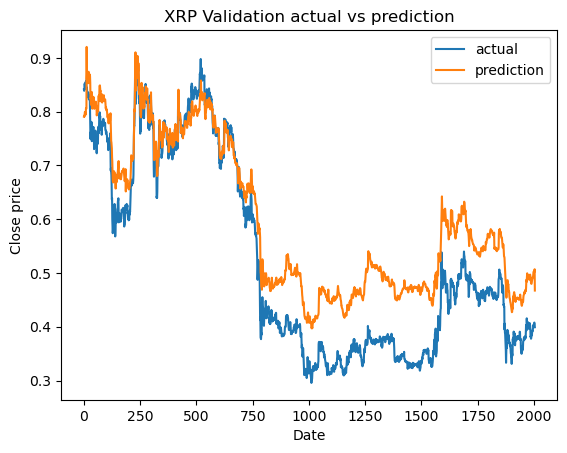



---------
Epoch 21, Train || MSE: 0.0098677, MAE: 0.0622402, R2: -56.8871705, RMSE: 0.0753625
Epoch 21, Evaluation || MSE: 0.0073225, MAE: 0.0743402, R2: -200.7160432, RMSE: 0.0755017


---------
Epoch 22, Train || MSE: 0.0099063, MAE: 0.0609263, R2: -58.8064699, RMSE: 0.0749799
Epoch 22, Evaluation || MSE: 0.0063415, MAE: 0.0695075, R2: -170.6223270, RMSE: 0.0706884


---------
Epoch 23, Train || MSE: 0.0096196, MAE: 0.0602687, R2: -64.5248221, RMSE: 0.0749867
Epoch 23, Evaluation || MSE: 0.0074489, MAE: 0.0746518, R2: -211.0037395, RMSE: 0.0757876


---------
Epoch 24, Train || MSE: 0.0091217, MAE: 0.0585895, R2: -61.4743005, RMSE: 0.0740438
Epoch 24, Evaluation || MSE: 0.0068466, MAE: 0.0725872, R2: -192.9145680, RMSE: 0.0737779


---------
Epoch 25, Train || MSE: 0.0094838, MAE: 0.0584965, R2: -60.8970874, RMSE: 0.0744477
Epoch 25, Evaluation || MSE: 0.0080252, MAE: 0.0774451, R2: -225.9580242, RMSE: 0.0785993


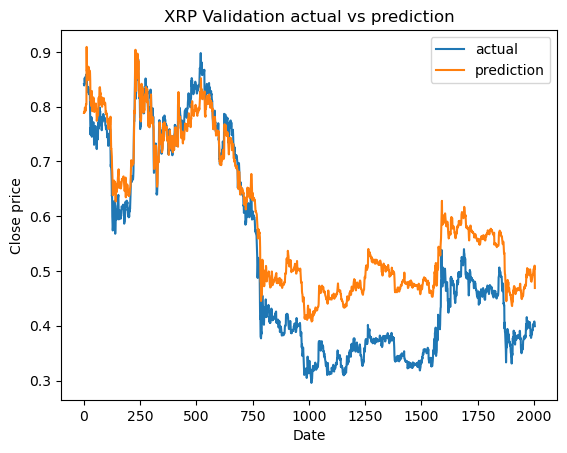



---------
Epoch 26, Train || MSE: 0.0092973, MAE: 0.0574154, R2: -55.1556950, RMSE: 0.0730087
Epoch 26, Evaluation || MSE: 0.0107556, MAE: 0.0904075, R2: -301.3712640, RMSE: 0.0915549


---------
Epoch 27, Train || MSE: 0.0097229, MAE: 0.0577853, R2: -61.9878283, RMSE: 0.0745368
Epoch 27, Evaluation || MSE: 0.0127926, MAE: 0.0973535, R2: -352.6554056, RMSE: 0.0984471


---------
Epoch 28, Train || MSE: 0.0096671, MAE: 0.0591686, R2: -70.6442021, RMSE: 0.0757308
Epoch 28, Evaluation || MSE: 0.0122826, MAE: 0.0955368, R2: -335.0895899, RMSE: 0.0966439


---------
Epoch 29, Train || MSE: 0.0098429, MAE: 0.0596270, R2: -73.9366794, RMSE: 0.0760102
Epoch 29, Evaluation || MSE: 0.0094459, MAE: 0.0842790, R2: -264.3514923, RMSE: 0.0854572


---------
Epoch 30, Train || MSE: 0.0109250, MAE: 0.0600813, R2: -60.3795515, RMSE: 0.0767256
Epoch 30, Evaluation || MSE: 0.0124767, MAE: 0.0963197, R2: -343.3948384, RMSE: 0.0973710


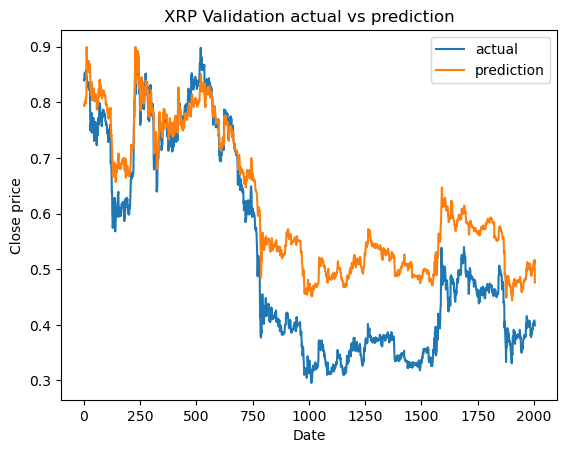

In [57]:
epochs = 30
learning_rate = 0.001
loss_function = nn.MSELoss()
# num_hidden_units = (64, 128)
num_hidden_units = 128
num_of_layers = 1
batch_size = 16
sequence_length = 16
coin_results, predictions_df, actual_df = train_all_coins(available_coins, epochs, learning_rate, loss_function,
                                                          num_hidden_units, num_of_layers, batch_size, sequence_length)

### Save results


In [4]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
predictions_df, actual_df = append_means(predictions_df, actual_df)
predictions_df.to_csv(f'./io/output/exports/lstm_exports/predictions/LSTM_predictions_{timestamp}_epochs_{epochs}.csv')
actual_df.to_csv(f'./io/output/exports/lstm_exports/actual/LSTM_actual_{timestamp}_epochs_{epochs}.csv')
print('Dataframes saved!')

mean_results = compute_mean_metrics(coin_results=coin_results)
print(f"mean mse: {round(mean_results['mean_mse'], 6)}")
print(f"mean mae: {round(mean_results['mean_mae'], 6)}")
print(f"mean r2: {round(mean_results['mean_r2'], 6)}")
print(f"mean rmse: {round(mean_results['mean_rmse'], 6)}")

# Save the dictionary to a file
with open('./io/output/exports/lstm_exports/metrics/lstm_metrics.json', 'a') as f:
    json.dump(mean_results, f, indent=len(mean_results))
print("Results saved to json file!")

In [35]:
pred_df = pd.read_csv('./io/output/exports/lstm_exports/predictions/LSTM_predictions_2023-05-30-10-42-27_epochs_30.csv', index_col=0, parse_dates=True)
actual_df = pd.read_csv('./io/output/exports/lstm_exports/actual/LSTM_actual_2023-05-30-10-42-27_epochs_30.csv', index_col=0, parse_dates=True)

In [57]:
def plot_test_actual_vs_pred(actual_df, pred_df, coin):
#     plot_df = pd.DataFrame(index=pred_df.index)
    plt.figure(figsize=(12, 8))
    predictions = pred_df[coin]
    actual_values = actual_df[coin]
    plt.plot(pred_df.index, predictions, label='Predictions')
    plt.plot(pred_df.index, actual_values, label='Actual')

    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.title(f'{coin}: Closes vs Predictions')
    
    plt.savefig(join(metrics_plot_path, f'LSTM_{coin}_pred_vs_true.png'))
    plt.show()

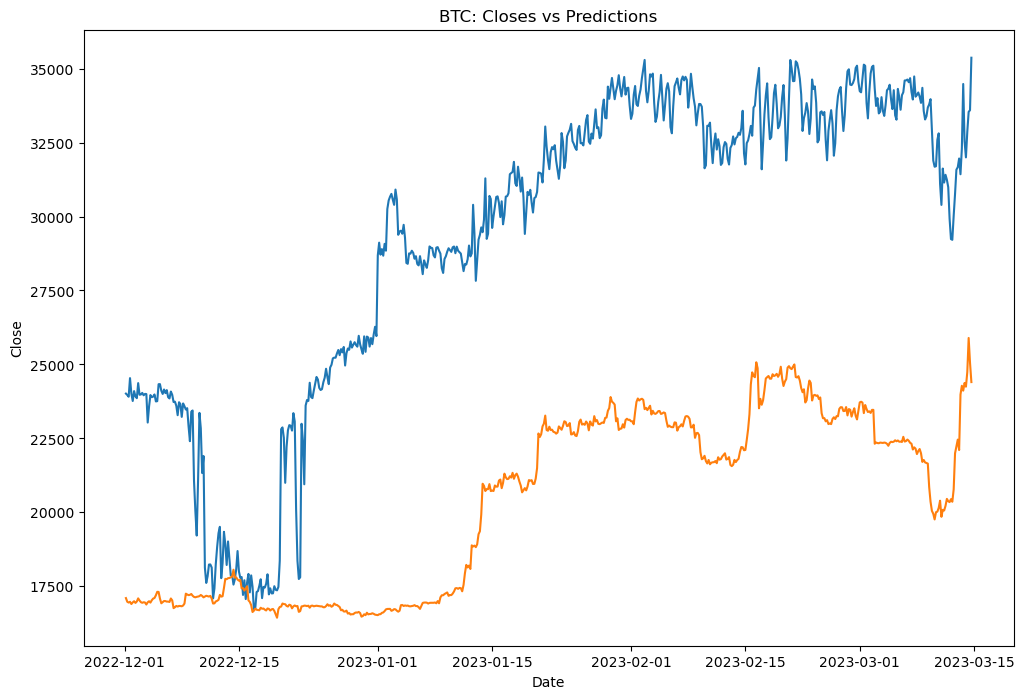

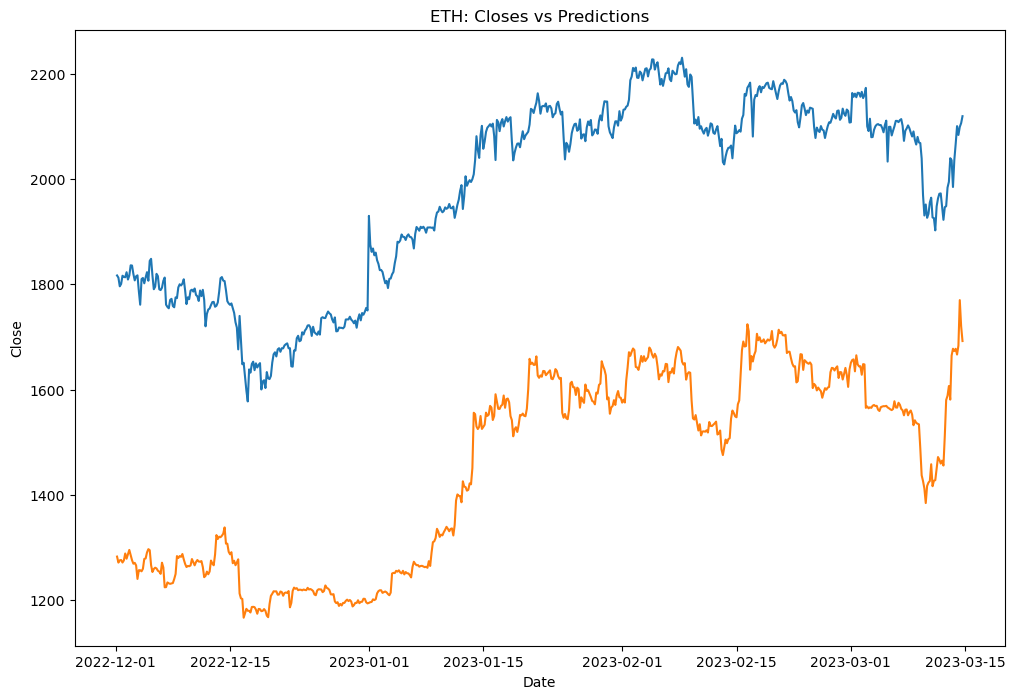

In [58]:
coins_for_plot = ['BTC', 'ETH']
for coin in coins_for_plot:
    plot_test_actual_vs_pred(actual_df=actual_df,pred_df=pred_df, coin=coin)